In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import skew, kurtosis
import seaborn as sns


In [2]:
df = pd.read_csv('cardio_train.csv', delimiter=';')
X = df.drop(['id', 'height'], axis=1)
X['age'] = X['age']/365
X['age'] = round(X['age'])

In [3]:
X

,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2,62.0,110,80,1,1,0,0,1,0
1,55.0,1,85.0,140,90,3,1,0,0,1,1
2,52.0,1,64.0,130,70,3,1,0,0,0,1
3,48.0,2,82.0,150,100,1,1,0,0,1,1
4,48.0,1,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,53.0,2,76.0,120,80,1,1,1,0,1,0
69996,62.0,1,126.0,140,90,2,2,0,0,1,1
69997,52.0,2,105.0,180,90,3,1,0,1,0,1
69998,61.0,1,72.0,135,80,1,2,0,0,0,1


age
56.0    6031
54.0    5988
58.0    5702
60.0    5465
52.0    5303
50.0    5267
62.0    3926
64.0    3920
48.0    3194
46.0    2955
44.0    2837
40.0    2700
42.0    2624
55.0    1498
57.0    1452
53.0    1407
59.0    1355
51.0    1348
61.0    1221
49.0    1059
63.0    1016
41.0     766
45.0     757
47.0     754
43.0     690
39.0     409
65.0     352
30.0       4
Name: count, dtype: int64


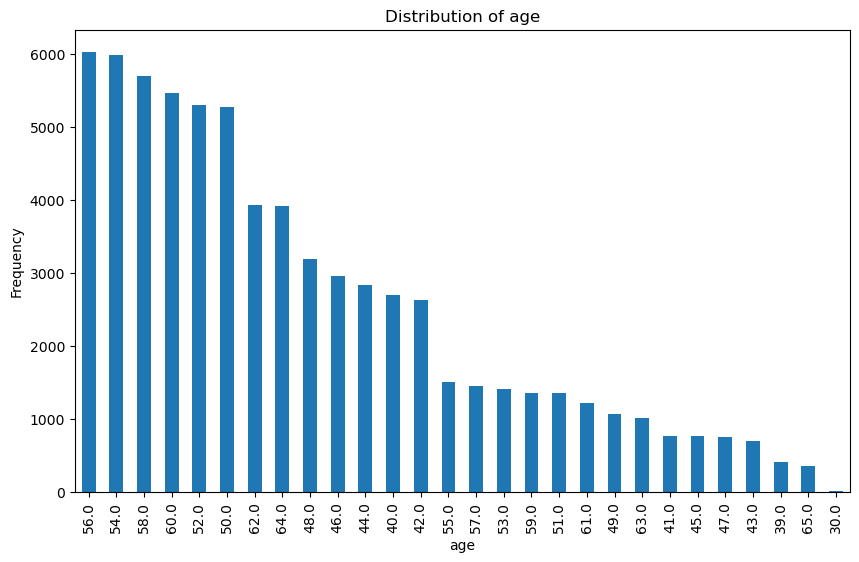

gender
1    45530
2    24470
Name: count, dtype: int64


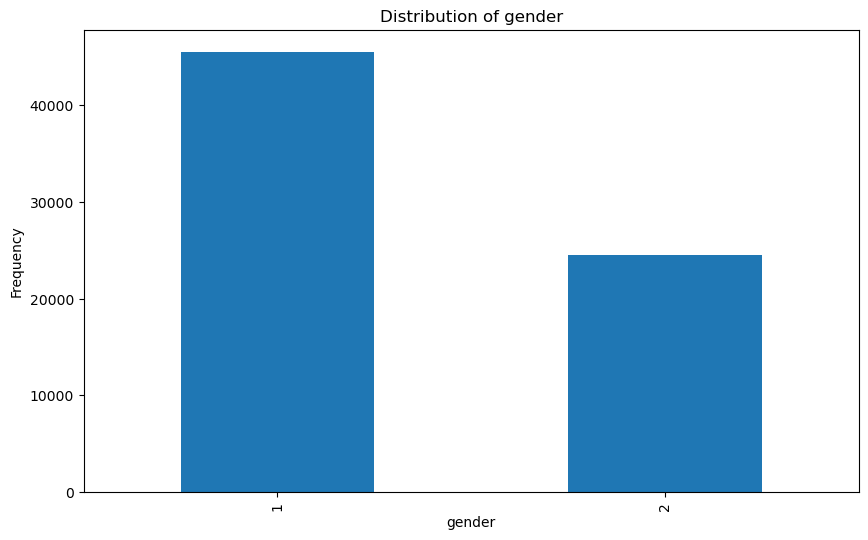

weight
65.0    3850
70.0    3764
68.0    2831
75.0    2740
60.0    2710
        ... 
92.2       1
75.6       1
82.9       1
23.0       1
99.9       1
Name: count, Length: 287, dtype: int64


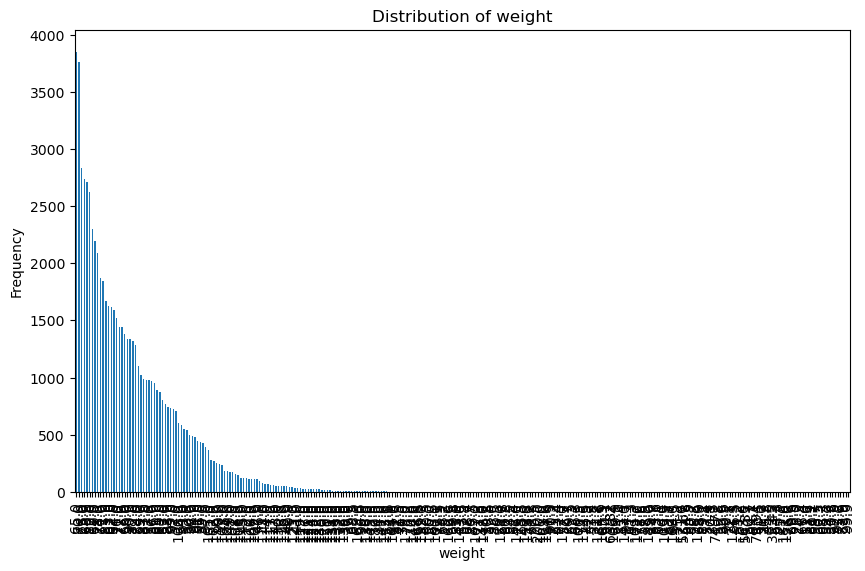

ap_hi
 120     27699
 140      9506
 130      8961
 110      8644
 150      4450
         ...  
 1620        1
 199         1
-150         1
-115         1
 2000        1
Name: count, Length: 153, dtype: int64


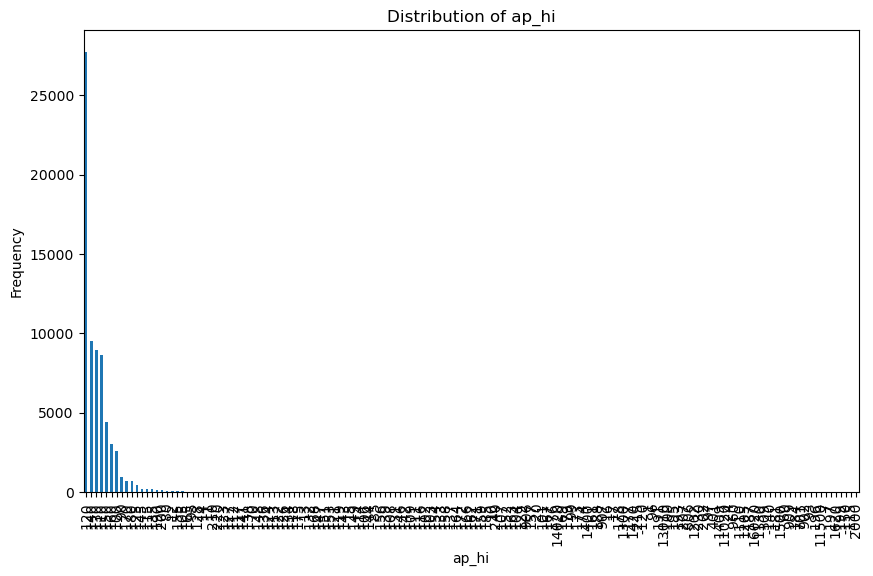

ap_lo
80     34847
90     14316
70     10245
100     4082
60      2727
       ...  
56         1
182        1
810        1
9          1
602        1
Name: count, Length: 157, dtype: int64


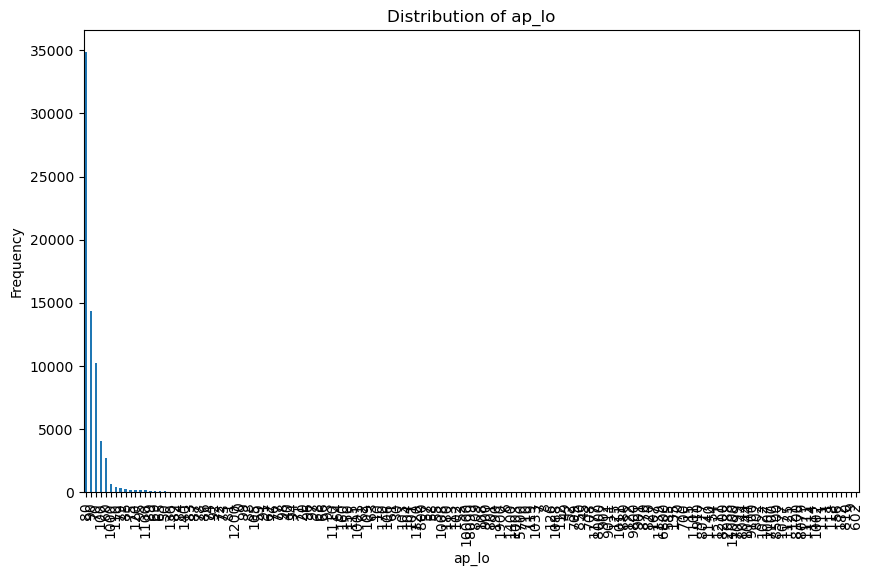

cholesterol
1    52385
2     9549
3     8066
Name: count, dtype: int64


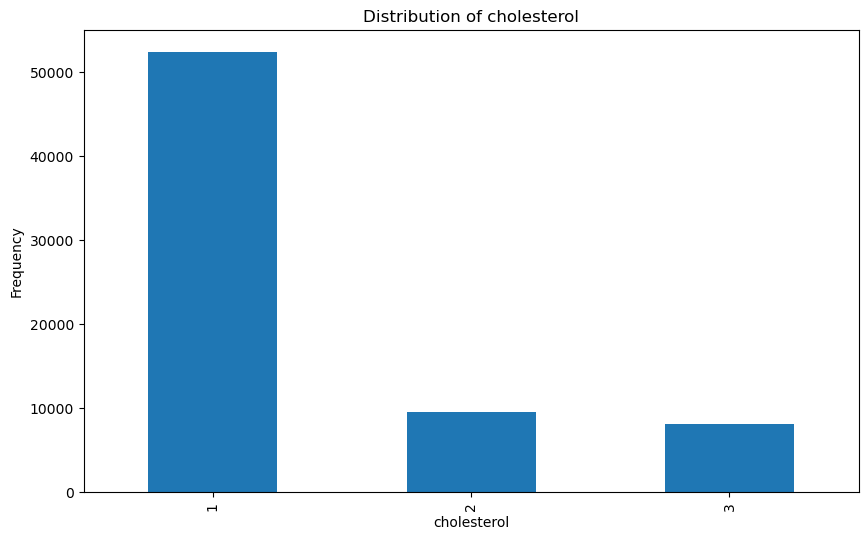

gluc
1    59479
3     5331
2     5190
Name: count, dtype: int64


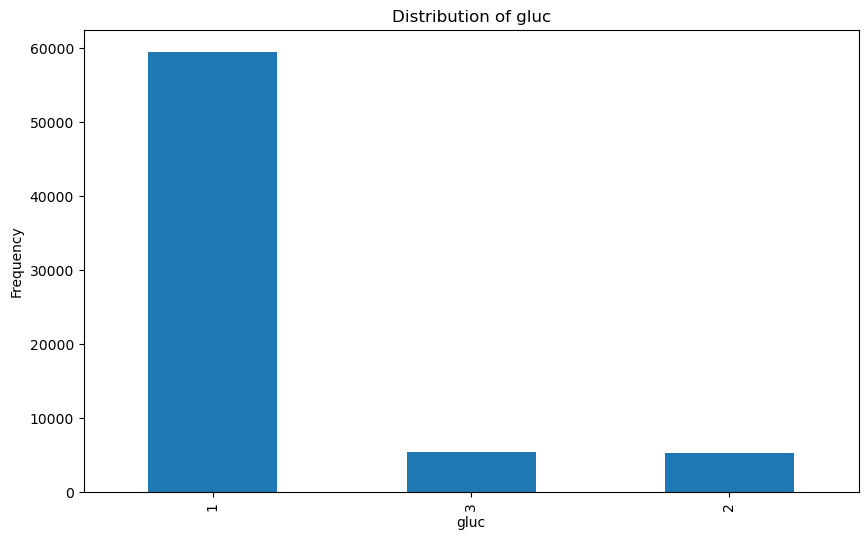

smoke
0    63831
1     6169
Name: count, dtype: int64


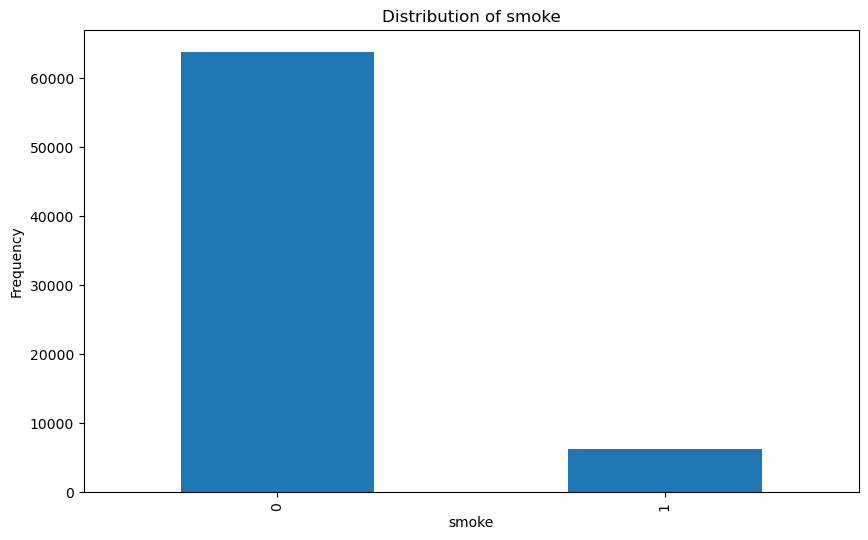

alco
0    66236
1     3764
Name: count, dtype: int64


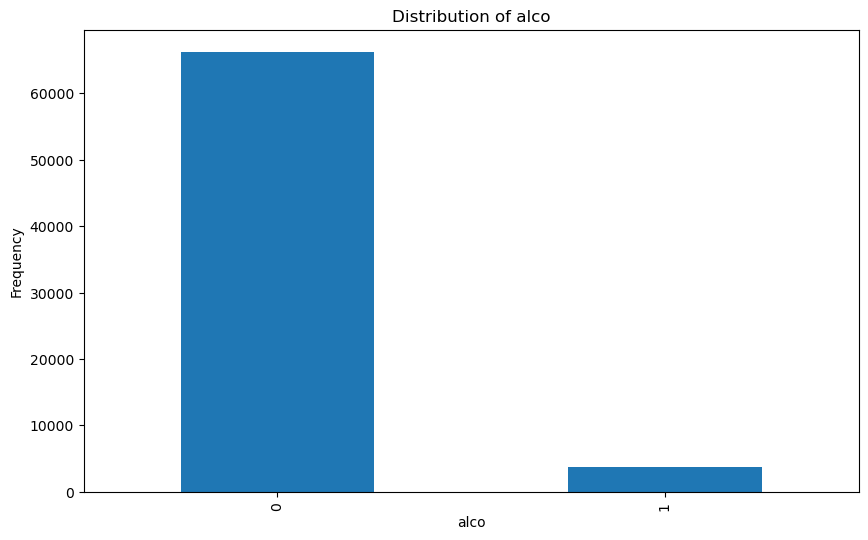

active
1    56261
0    13739
Name: count, dtype: int64


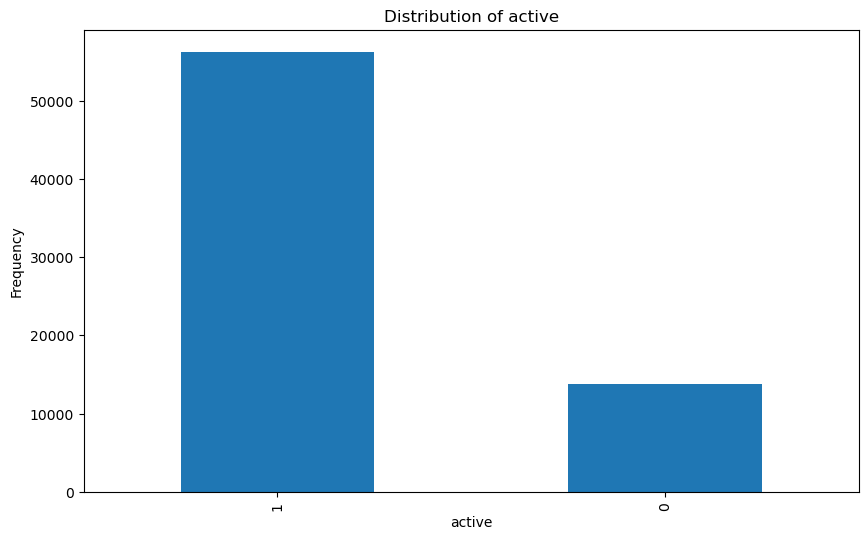

cardio
0    35021
1    34979
Name: count, dtype: int64


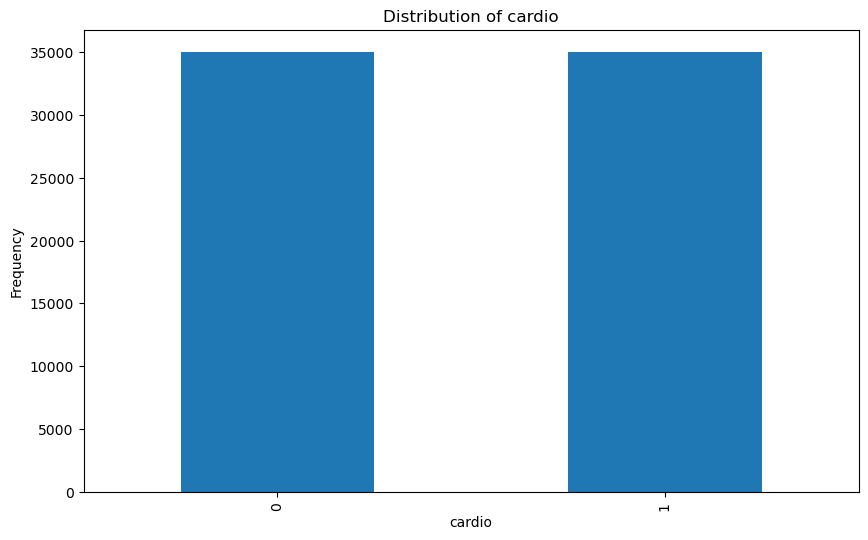

In [4]:
for column in X.columns:
        value_counts = X[column].value_counts()
        print(value_counts)
        
        plt.figure(figsize=(10, 6))
        value_counts.plot(kind='bar')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

# Up-Down Sampling

In [6]:
from sklearn.utils import resample

def balance_column(X, column_name):
    majority_class = X[column_name].mode()[0]
    minority_class = 1 - majority_class

    majority_df = X[X[column_name] == majority_class]
    minority_df = X[X[column_name] == minority_class]

    minority_df_upsampled = resample(minority_df,
                                     replace=True,                 
                                     n_samples=len(majority_df),    
                                     random_state=42)               

    balanced_df = pd.concat([majority_df, minority_df_upsampled])
    balanced_df.reset_index(drop=True, inplace=True)
    
    return balanced_df

balanced_smoke = balance_column(X, 'smoke')
balanced_alco = balance_column(X, 'alco')
balanced_active = balance_column(X, 'active')

data_without_columns = X.drop(['smoke', 'alco', 'active'], axis=1)

data_resampled = data_without_columns.join(balanced_smoke['smoke']).join(balanced_alco['alco']).join(balanced_active['active'])
data_resampled

,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,cardio,smoke,alco,active
0,50.0,2,62.0,110,80,1,1,0,0,0,1
1,55.0,1,85.0,140,90,3,1,1,0,0,1
2,52.0,1,64.0,130,70,3,1,1,0,0,1
3,48.0,2,82.0,150,100,1,1,1,0,0,1
4,48.0,1,56.0,100,60,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
69995,53.0,2,76.0,120,80,1,1,0,1,1,0
69996,62.0,1,126.0,140,90,2,2,1,1,1,0
69997,52.0,2,105.0,180,90,3,1,1,1,1,0
69998,61.0,1,72.0,135,80,1,2,1,1,1,0


In [8]:
target_distribution = X['smoke'].value_counts()
print(target_distribution)

smoke
0    63831
1     6169
Name: count, dtype: int64


# SMOTE

In [9]:
def balance_data_rounded_numeric_only(data, column, target_counts):
    
    balanced_data = X.copy()
    classes = X[column].unique()

    numeric_columns = X.select_dtypes(include=np.number).columns.tolist()

    for class_ in classes:
        class_subset = X[X[column] == class_]
        class_count = class_subset.shape[0]

        if class_count < target_counts:
            samples_to_generate = target_counts - class_count

            samples = class_subset.sample(n=samples_to_generate, replace=True)

            noise = np.random.normal(0, 0.01, samples[numeric_columns].shape)
            synthetic_samples = samples.copy()
            synthetic_samples[numeric_columns] = (samples[numeric_columns] + noise).round()

            balanced_data = pd.concat([balanced_data, synthetic_samples])

    return balanced_data

max_sample_count= X.shape[0]

balanced_data_combined = X.copy()
for column in ['gluc', 'smoke', 'alco', 'active']:
    balanced_data_combined = balance_data_rounded_numeric_only(balanced_data_combined, column, max_sample_count)

new_gluc_dist_combined = balanced_data_combined['gluc'].value_counts()
new_smoke_dist_combined = balanced_data_combined['smoke'].value_counts()
new_alco_dist_combined = balanced_data_combined['alco'].value_counts()
new_active_dist_combined = balanced_data_combined['active'].value_counts()

new_gluc_dist_combined, new_smoke_dist_combined, new_alco_dist_combined, new_active_dist_combined

(gluc
 1.0    118651
 2.0     10679
 3.0     10670
 Name: count, dtype: int64,
 smoke
 0.0    128418
 1.0     11582
 Name: count, dtype: int64,
 alco
 0.0    133074
 1.0      6926
 Name: count, dtype: int64,
 active
 1.0    70000
 0.0    70000
 Name: count, dtype: int64)

# Mode, Median and Mean visualization

In [10]:
continous_features =['ap_hi', 'ap_lo','weight'] #continuous features

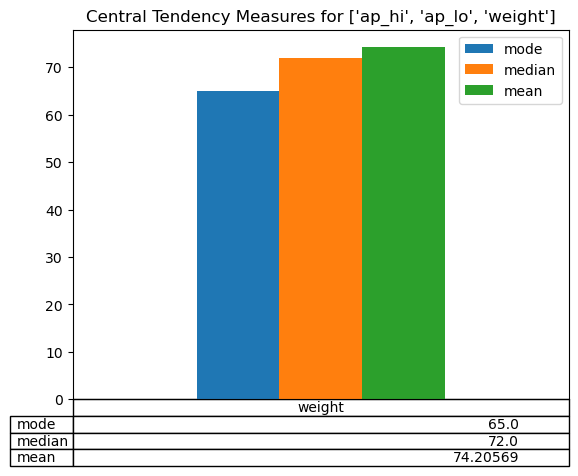

In [11]:
for feature in continous_features:
    X_ct = pd.DataFrame()
    X_ct["mode"] = X.loc[:, [feature]].mode().iloc[0, :]
    X_ct["median"] = X.loc[:, [feature]].median()
    X_ct["mean"] = X.loc[:, [feature]].mean()


X_ct.plot.bar(title =f"Central Tendency Measures for {continous_features}" )
plt.xticks([])
table = plt.table(cellText=X_ct.T.values, colLabels=X_ct.T.columns,
                      rowLabels=X_ct.T.index, fontsize=180)
plt.show()

# Skewness and Kurtosis

In [12]:
skewness = X[continous_features].skew()
kurtosis_values = X[continous_features].apply(kurtosis)

print("Skewness:")
print(skewness)
print("\nKurtosis:")
print(kurtosis_values)

Skewness:
ap_hi     85.296214
ap_lo     32.114083
weight     1.012070
dtype: float64

Kurtosis:
ap_hi     7579.533229
ap_lo     1425.812650
weight       2.586555
dtype: float64


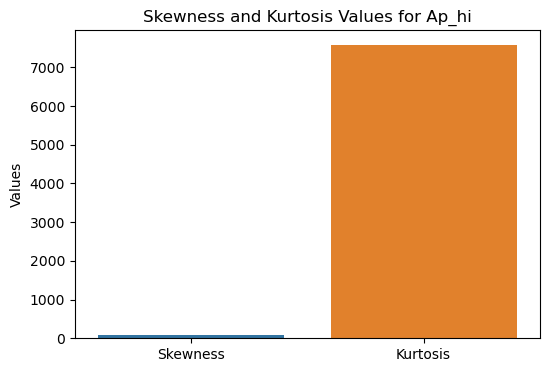

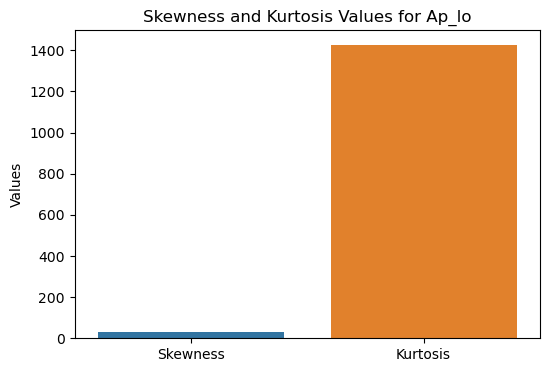

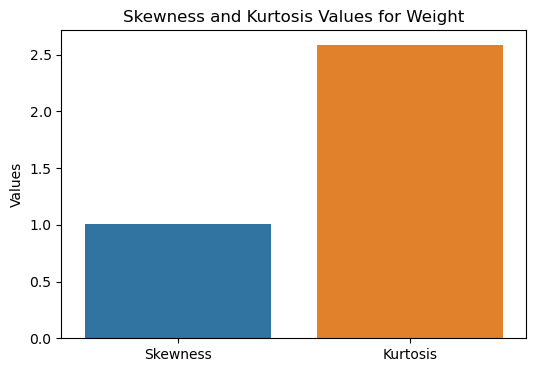

In [14]:
skewness_kurtosis = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis_values}, index=continous_features)

# ap_hi 
plt.figure(figsize=(6, 4))
sns.barplot(data=skewness_kurtosis.loc[['ap_hi']])
plt.title('Skewness and Kurtosis Values for Ap_hi')
plt.ylabel('Values')
plt.show()

# ap_lo 
plt.figure(figsize=(6, 4))
sns.barplot(data=skewness_kurtosis.loc[['ap_lo']])
plt.title('Skewness and Kurtosis Values for Ap_lo')
plt.ylabel('Values')
plt.show()

# weight 
plt.figure(figsize=(6, 4))
sns.barplot(data=skewness_kurtosis.loc[['weight']])
plt.title('Skewness and Kurtosis Values for Weight')
plt.ylabel('Values')
plt.show()


In [15]:
X

,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2,62.0,110,80,1,1,0,0,1,0
1,55.0,1,85.0,140,90,3,1,0,0,1,1
2,52.0,1,64.0,130,70,3,1,0,0,0,1
3,48.0,2,82.0,150,100,1,1,0,0,1,1
4,48.0,1,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,53.0,2,76.0,120,80,1,1,1,0,1,0
69996,62.0,1,126.0,140,90,2,2,0,0,1,1
69997,52.0,2,105.0,180,90,3,1,0,1,0,1
69998,61.0,1,72.0,135,80,1,2,0,0,0,1


# Normalize

In [16]:
from sklearn.preprocessing import StandardScaler

columns_to_normalize = ['ap_hi', 'ap_lo', 'weight']
scaler = StandardScaler()
normalize=X.copy()
normalize[columns_to_normalize] = scaler.fit_transform(normalize[columns_to_normalize])

normalize

,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2,-0.847873,-0.122182,-0.088238,1,1,0,0,1,0
1,55.0,1,0.749831,0.072610,-0.035180,3,1,0,0,1,1
2,52.0,1,-0.708942,0.007679,-0.141297,3,1,0,0,0,1
3,48.0,2,0.541435,0.137541,0.017879,1,1,0,0,1,1
4,48.0,1,-1.264666,-0.187113,-0.194356,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,53.0,2,0.124642,-0.057251,-0.088238,1,1,1,0,1,0
69996,62.0,1,3.597913,0.072610,-0.035180,2,2,0,0,1,1
69997,52.0,2,2.139139,0.332333,-0.035180,3,1,0,1,0,1
69998,61.0,1,-0.153219,0.040145,-0.088238,1,2,0,0,0,1


In [42]:
X

,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2,62.0,110,80,1,1,0,0,1,0
1,55.0,1,85.0,140,90,3,1,0,0,1,1
2,52.0,1,64.0,130,70,3,1,0,0,0,1
3,48.0,2,82.0,150,100,1,1,0,0,1,1
4,48.0,1,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,53.0,2,76.0,120,80,1,1,1,0,1,0
69996,62.0,1,126.0,140,90,2,2,0,0,1,1
69997,52.0,2,105.0,180,90,3,1,0,1,0,1
69998,61.0,1,72.0,135,80,1,2,0,0,0,1


In [18]:
X.describe().T.style.set_properties()

,count,mean,std,min,25%,50%,75%,max
age,70000.000000,53.338686,6.765294,30.000000,48.000000,54.000000,58.000000,65.000000
gender,70000.000000,1.349571,0.476838,1.000000,1.000000,1.000000,2.000000,2.000000
weight,70000.000000,74.205690,14.395757,10.000000,65.000000,72.000000,82.000000,200.000000
ap_hi,70000.000000,128.817286,154.011419,-150.000000,120.000000,120.000000,140.000000,16020.000000
ap_lo,70000.000000,96.630414,188.472530,-70.000000,80.000000,80.000000,90.000000,11000.000000
cholesterol,70000.000000,1.366871,0.680250,1.000000,1.000000,1.000000,2.000000,3.000000
gluc,70000.000000,1.226457,0.572270,1.000000,1.000000,1.000000,1.000000,3.000000
smoke,70000.000000,0.088129,0.283484,0.000000,0.000000,0.000000,0.000000,1.000000
alco,70000.000000,0.053771,0.225568,0.000000,0.000000,0.000000,0.000000,1.000000
active,70000.000000,0.803729,0.397179,0.000000,1.000000,1.000000,1.000000,1.000000


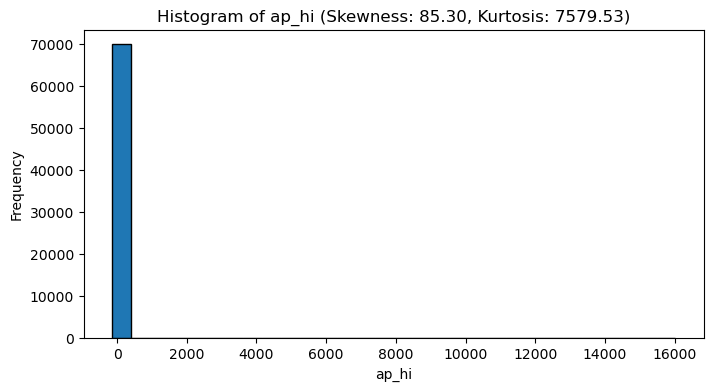

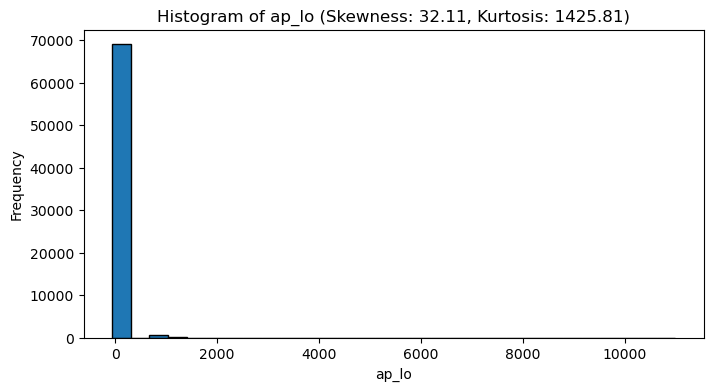

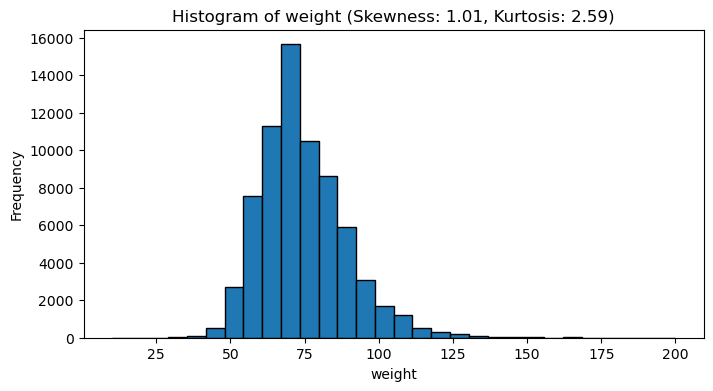

In [19]:
for feature in continous_features:
    plt.figure(figsize=(8, 4))
    plt.hist(X[feature], bins=30, edgecolor='black')
    plt.title(f"Histogram of {feature} (Skewness: {skewness[feature]:.2f}, Kurtosis: {kurtosis_values[feature]:.2f})")
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Covariance Matrix

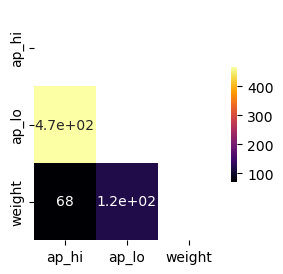

In [20]:
X_cov = X[continous_features].cov()

mask_cov = np.triu(np.ones_like(X_cov, dtype=bool))

plt.figure(figsize=(X_cov.shape[0], X_cov.shape[1]))
sns.heatmap(X_cov, mask=mask_cov, annot=True, cmap="inferno", cbar_kws={"shrink": .5})
plt.show()

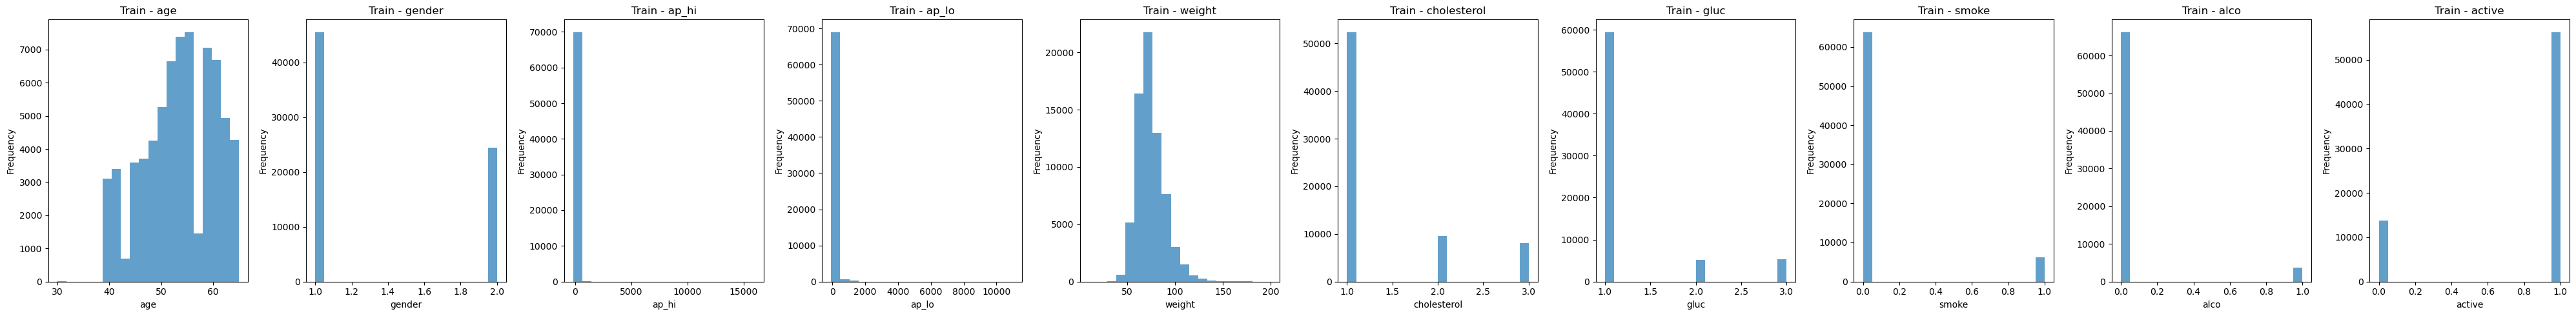

In [21]:
import matplotlib.pyplot as plt

features_to_plot = ['age','gender', 'ap_hi', 'ap_lo', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

plt.figure(figsize=(40,5))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, len(features_to_plot), i)
    plt.hist(X[feature], bins=20, alpha=0.7, label='Train')
    plt.title(f'Train - {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Data Cleaning Process


In [22]:
missing_values = X.isnull().sum()

print(missing_values)

age            0
gender         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


# IQR (Outlier detection)

In [23]:
# IQR Method for Outlier Detection in Training Set
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outliers_IQR= ((X < (Q1 - 1.5 * IQR)) | (X> (Q3 + 1.5 * IQR))).sum()

outliers_IQR

age                4
gender             0
weight          1819
ap_hi           1435
ap_lo           4632
cholesterol        0
gluc           10521
smoke           6169
alco            3764
active         13739
cardio             0
dtype: int64

C:\Users\HP\AppData\Local\Temp\ipykernel_18684\4083946034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_18684\4083946034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_18684\4083946034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_18684\4083946034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_18684\4083946034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_18684\4083946034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_18684\4083946034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_

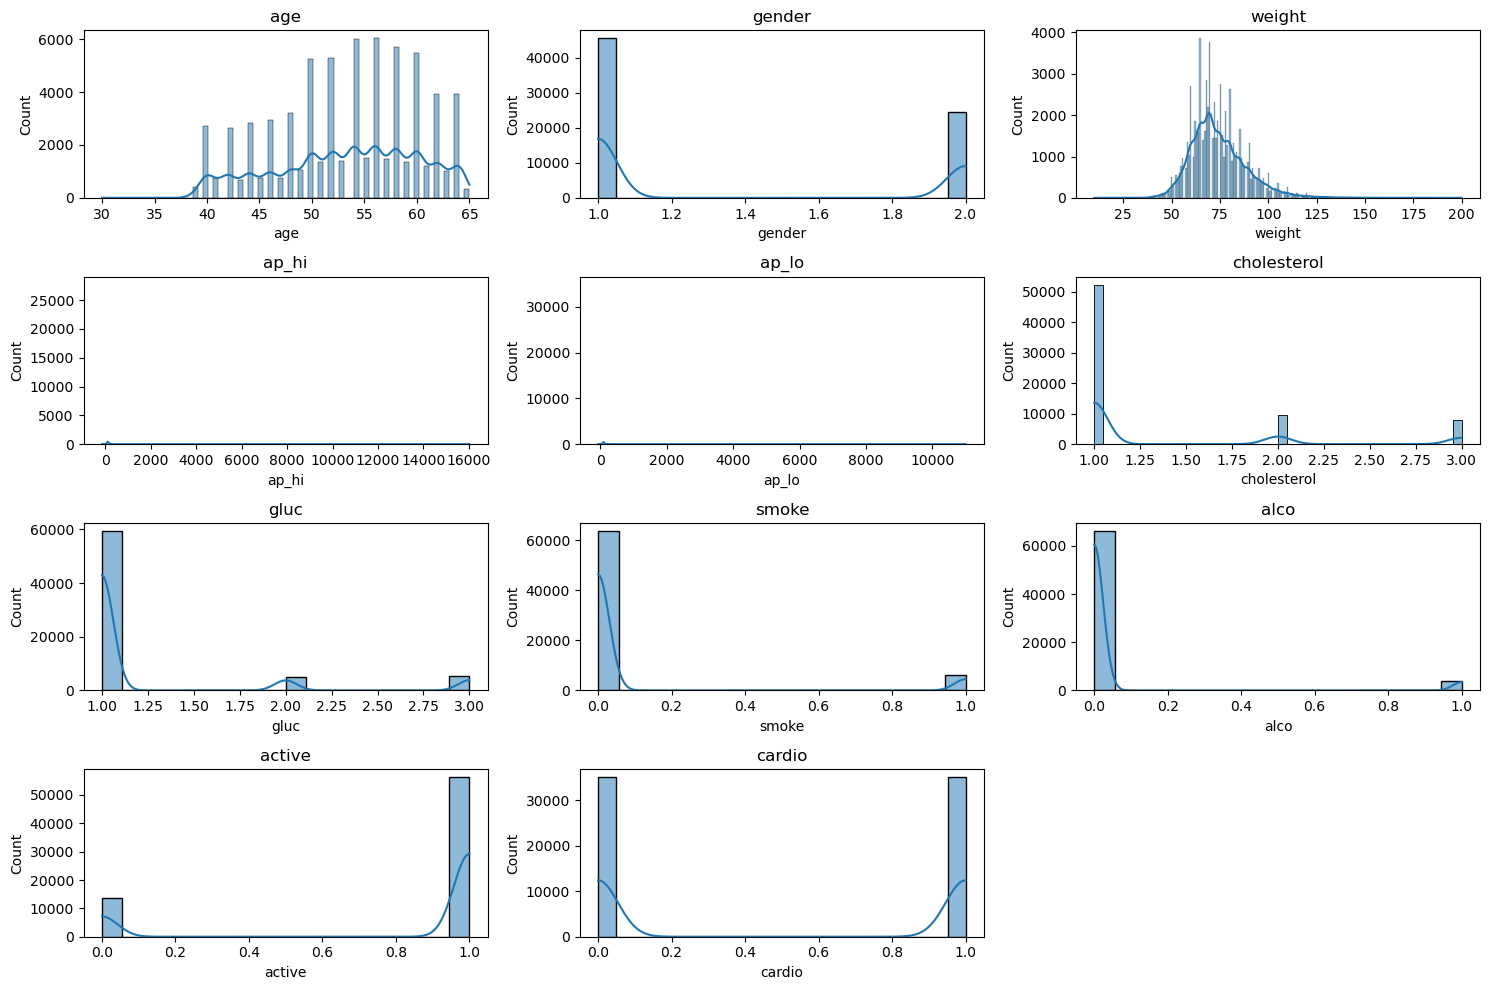

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i, col in enumerate(X.columns):
    plt.subplot(4, 3, i + 1)
    sns.histplot(X[col], kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()

### Since we could not correct the smoke alcohol and active data with data sampling and synthetic data operations in the future, we did not remove the outliers in the smoke, alcohol and active values from the dataset.

In [25]:
outlier_cols = [col for col in X.columns if col not in ['smoke', 'alco', 'active', 'gluc']]

Q1 = X[outlier_cols].quantile(0.25)
Q3 = X[outlier_cols].quantile(0.75)
IQR = Q3 - Q1

not_outlier_mask = ~((X[outlier_cols] < (Q1 - 1.5 * IQR)) | (X[outlier_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

X_no = X[not_outlier_mask]

print("X : ", X.shape)
print("Without outlier X : ", X_no.shape)

X :  (70000, 11)
Without outlier X :  (62919, 11)


age
56.0    5443
54.0    5404
58.0    5189
60.0    4958
52.0    4747
50.0    4735
62.0    3564
64.0    3531
48.0    2850
46.0    2620
44.0    2488
40.0    2380
42.0    2343
55.0    1357
57.0    1310
53.0    1264
59.0    1235
51.0    1227
61.0    1104
49.0     939
63.0     931
45.0     690
47.0     678
41.0     670
43.0     603
39.0     335
65.0     324
Name: count, dtype: int64


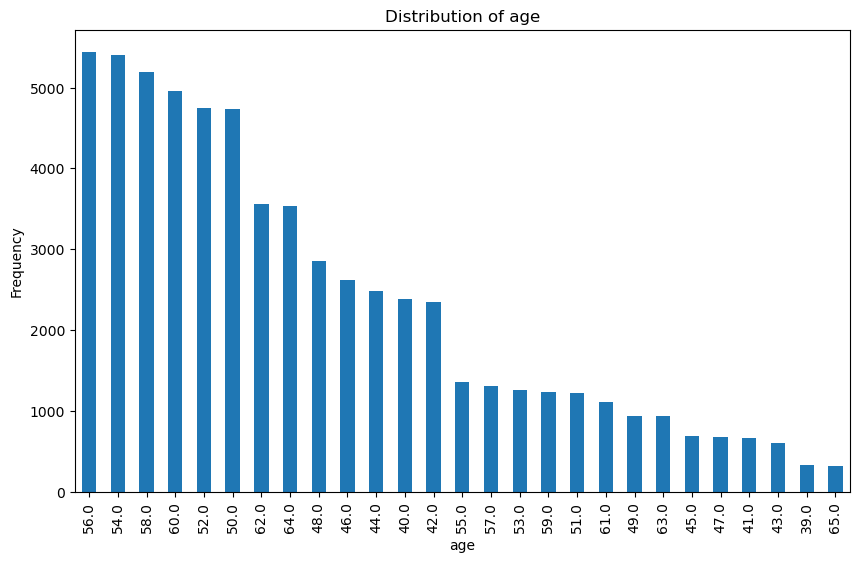

gender
1    40917
2    22002
Name: count, dtype: int64


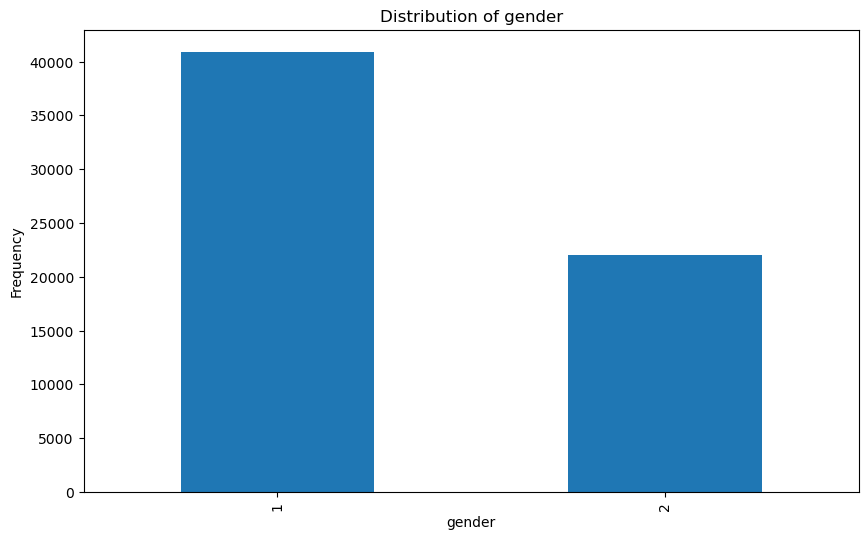

weight
65.0    3609
70.0    3542
68.0    2641
75.0    2567
60.0    2470
        ... 
62.2       1
65.3       1
60.2       1
68.4       1
99.9       1
Name: count, Length: 180, dtype: int64


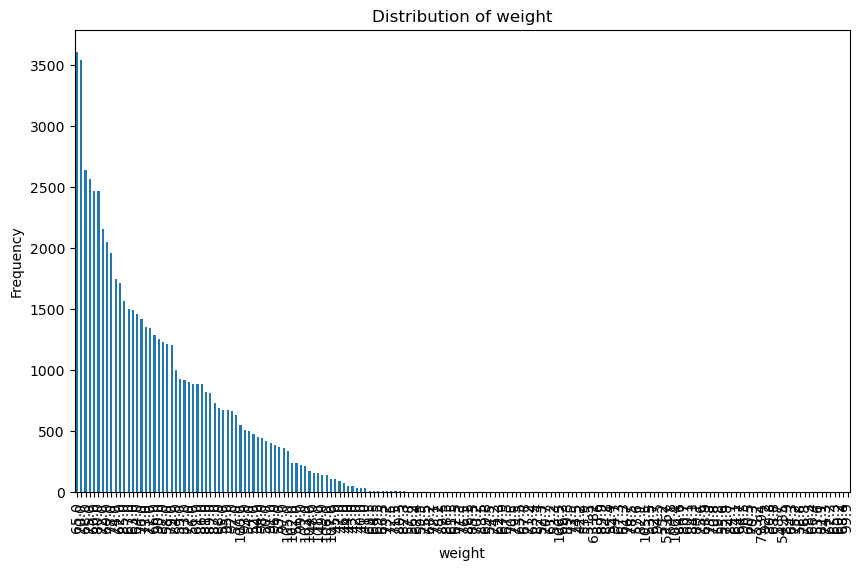

ap_hi
120    26814
140     8908
130     8501
110     8071
150     3942
       ...  
101        3
169        3
99         3
161        2
96         1
Name: count, Length: 75, dtype: int64


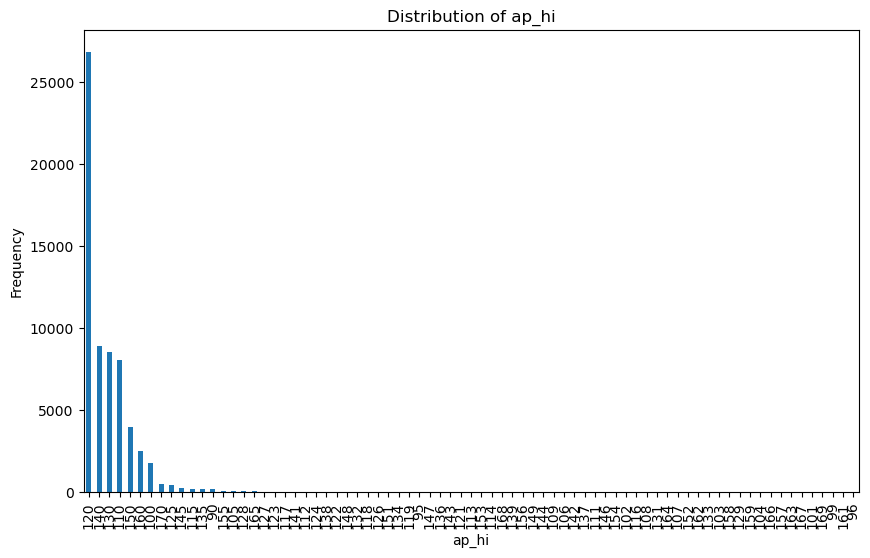

ap_lo
80     34035
90     13565
70     10081
100     3445
79       353
85       280
75       205
95       153
89       116
69        97
65        77
82        33
84        31
83        27
78        26
74        26
87        25
86        25
72        21
73        21
81        20
92        20
91        19
67        19
76        18
99        18
94        17
88        16
98        16
77        15
71        14
97        12
96        12
105       12
68        11
66        11
93        10
104        5
101        5
103        5
102        2
Name: count, dtype: int64


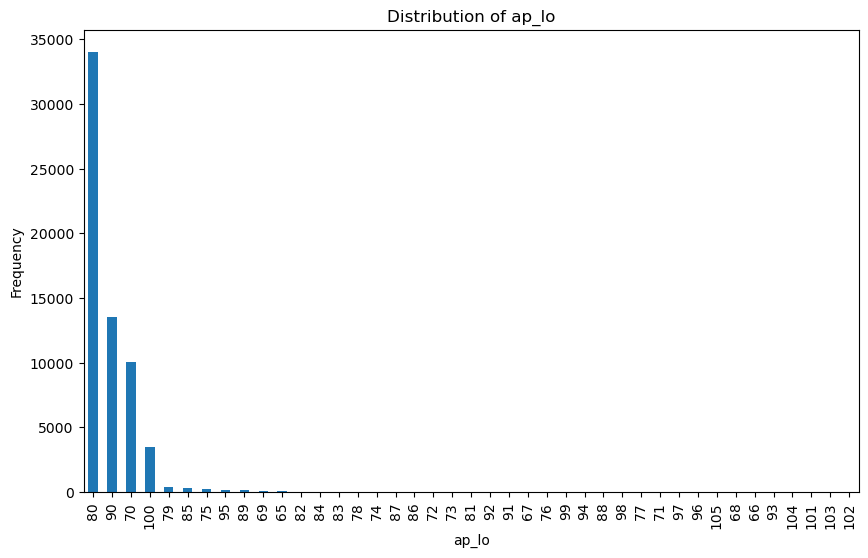

cholesterol
1    47544
2     8275
3     7100
Name: count, dtype: int64


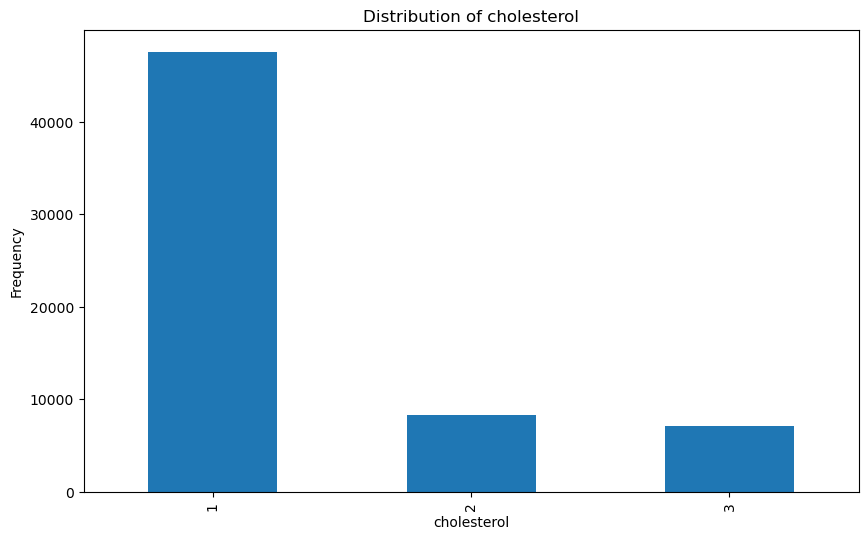

gluc
1    53775
3     4717
2     4427
Name: count, dtype: int64


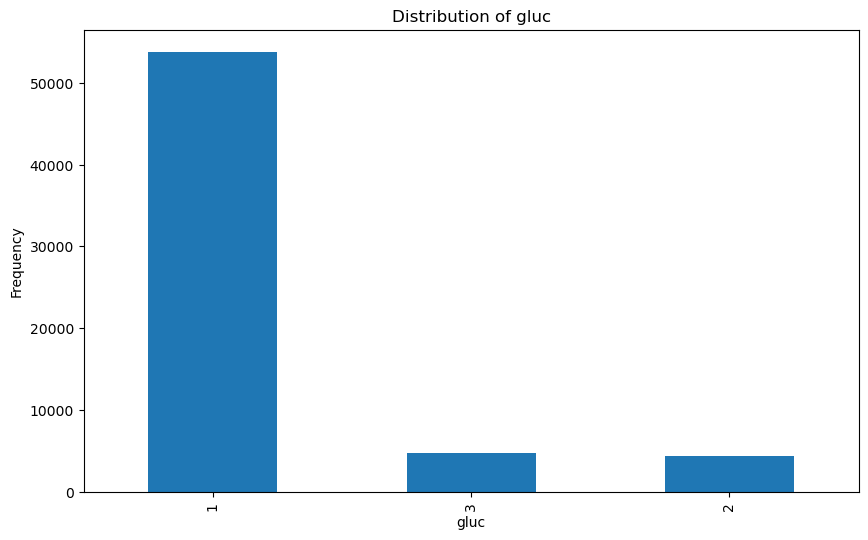

smoke
0    57475
1     5444
Name: count, dtype: int64


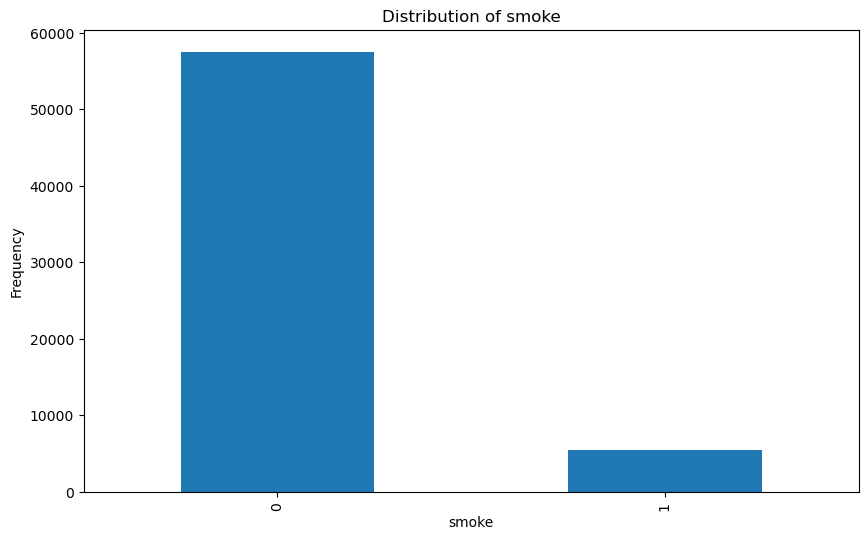

alco
0    59633
1     3286
Name: count, dtype: int64


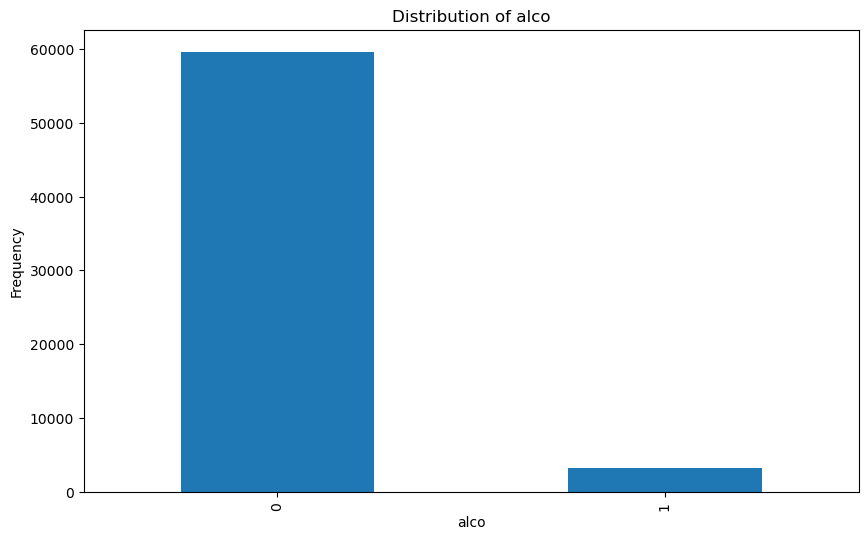

active
1    50584
0    12335
Name: count, dtype: int64


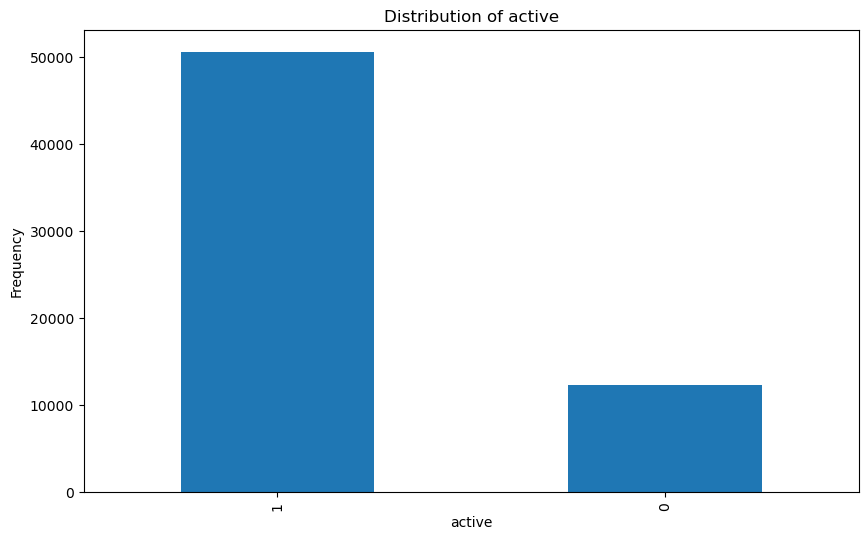

cardio
0    31839
1    31080
Name: count, dtype: int64


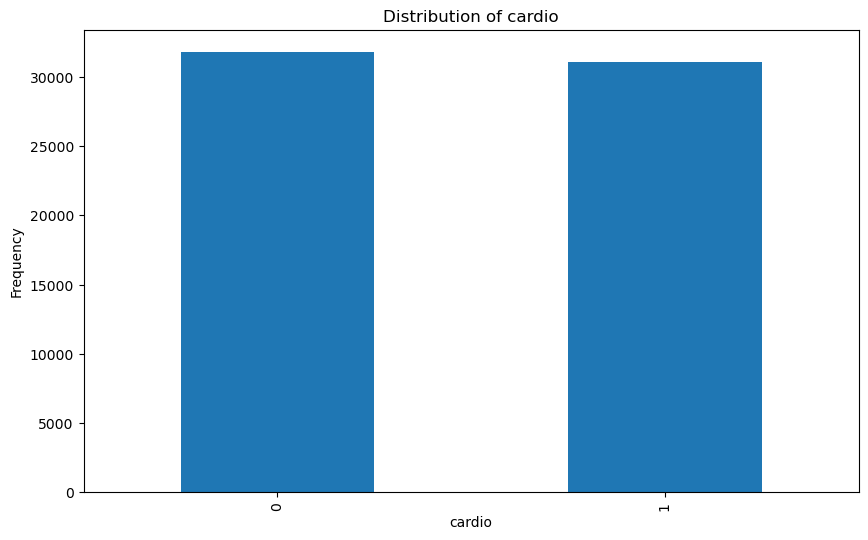

In [26]:
for column in X_no.columns:
        value_counts = X_no[column].value_counts()
        print(value_counts)
        
        plt.figure(figsize=(10, 6))
        value_counts.plot(kind='bar')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

# Isolation Forest (Outlier Detection)

In [27]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_no)

IsolationForest(contamination=0.01, random_state=42)

In [28]:
#Outliers for train
outliers_train_iso = iso_forest.predict(X_no)
normal_mask = outliers_train_iso != -1
X_no_iso = X_no[normal_mask]
X_no_iso 
X_no_iso1 = X_no[normal_mask].sum()
X_no_iso1

age            3326466.00
gender           83780.00
weight         4553027.38
ap_hi          7868077.00
ap_lo          5085462.00
cholesterol      84007.00
gluc             75527.00
smoke             5031.00
alco              2805.00
active           50215.00
cardio           30726.00
dtype: float64

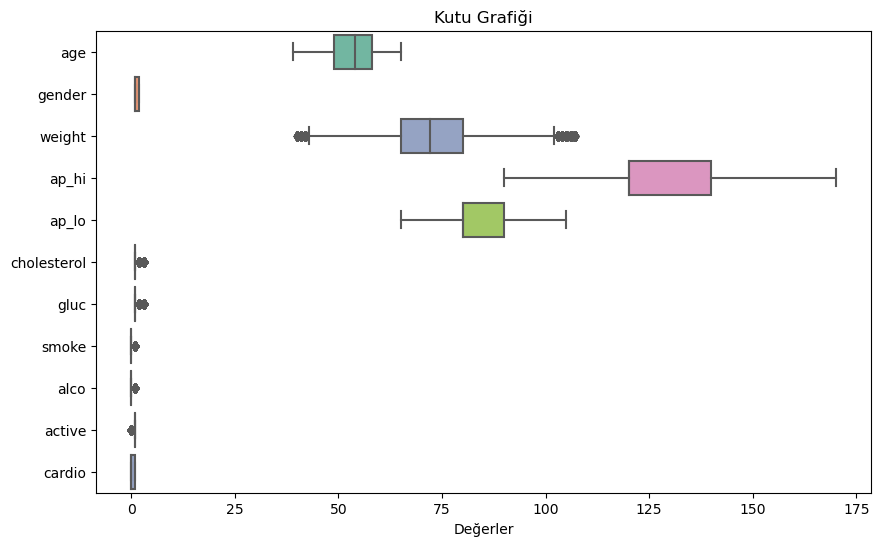

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_no_iso, orient='h', palette='Set2')
plt.title('Kutu Grafiği')
plt.xlabel('Değerler')
plt.show()

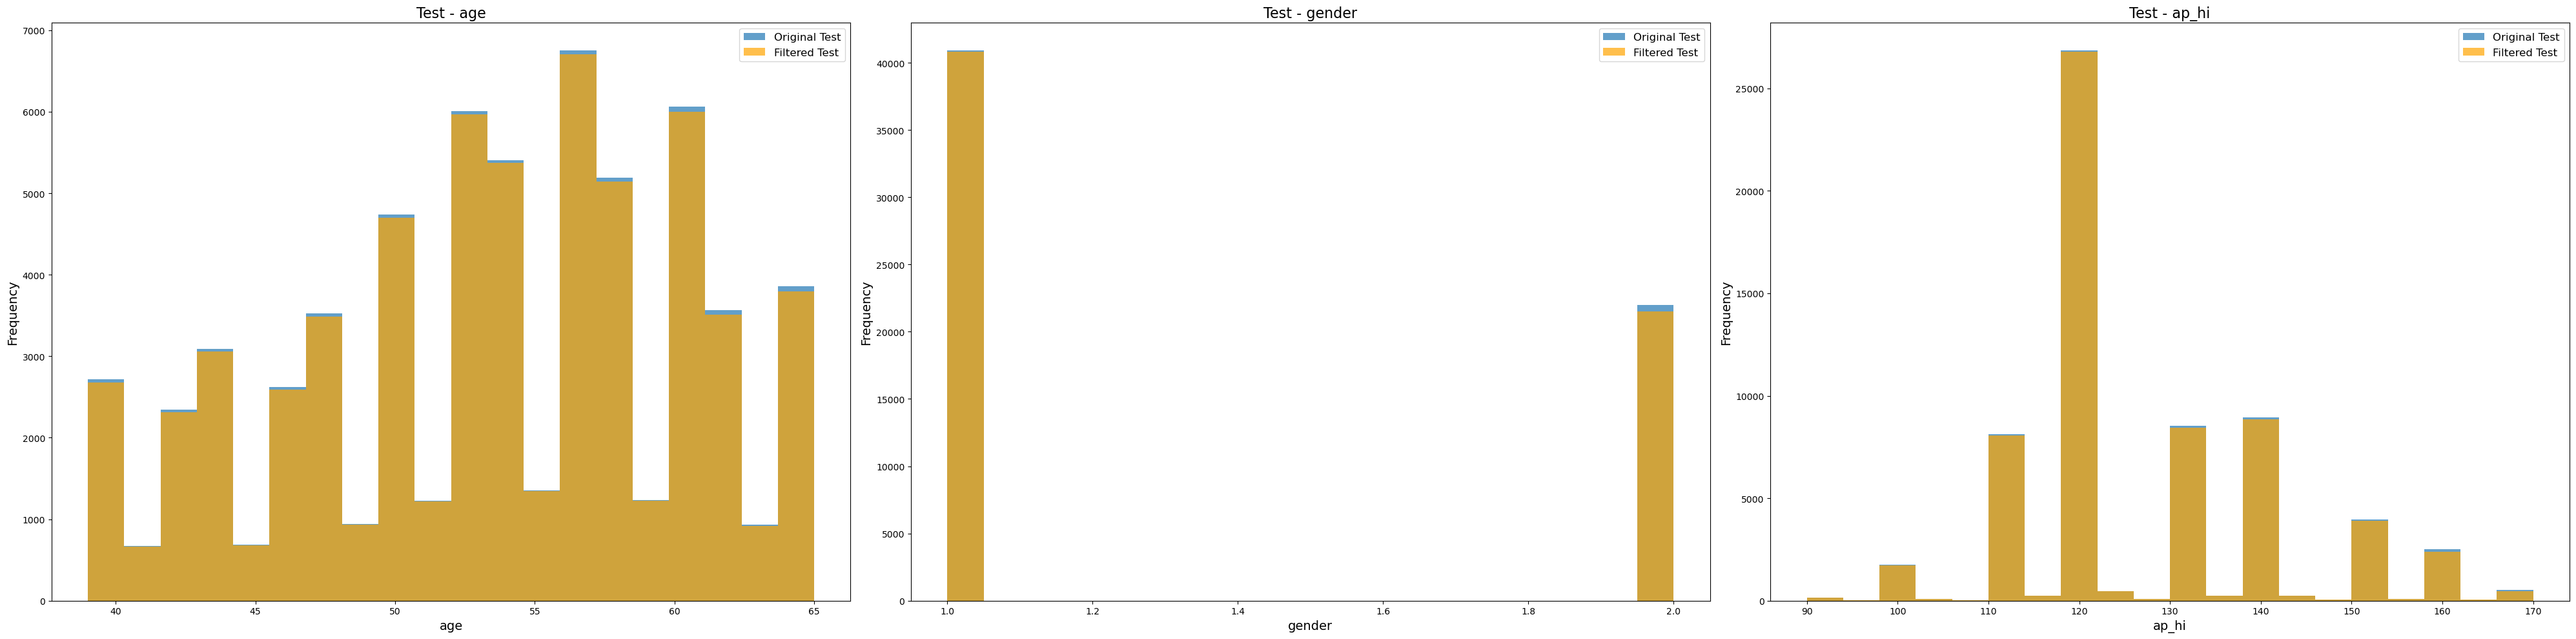

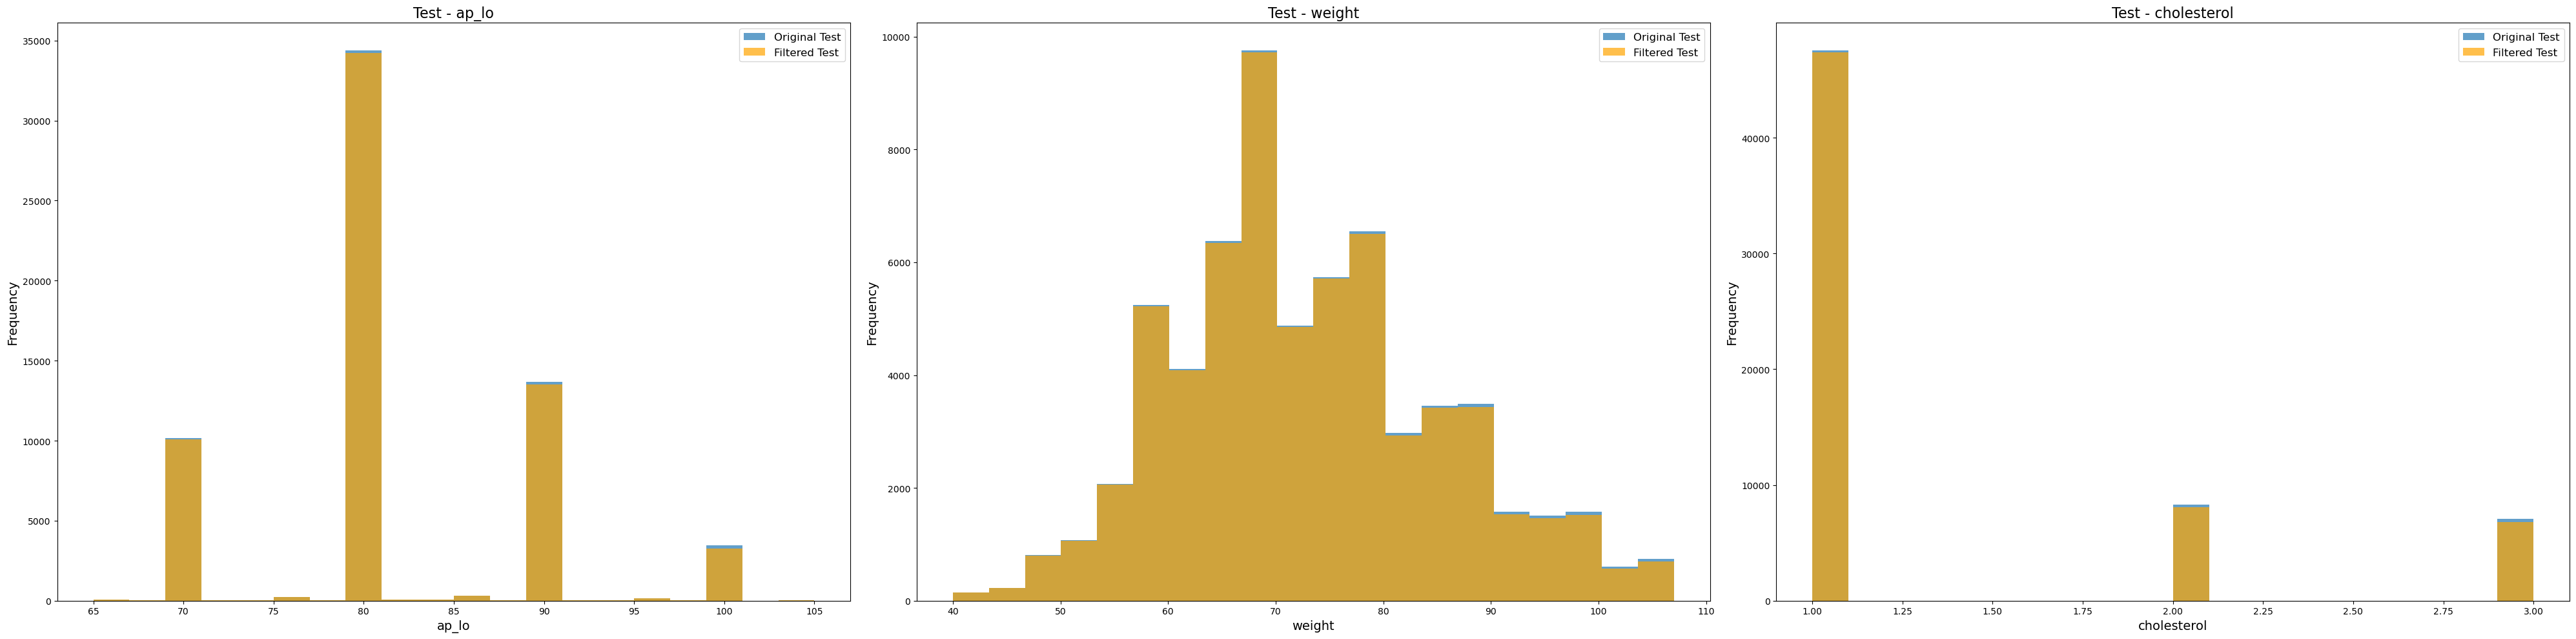

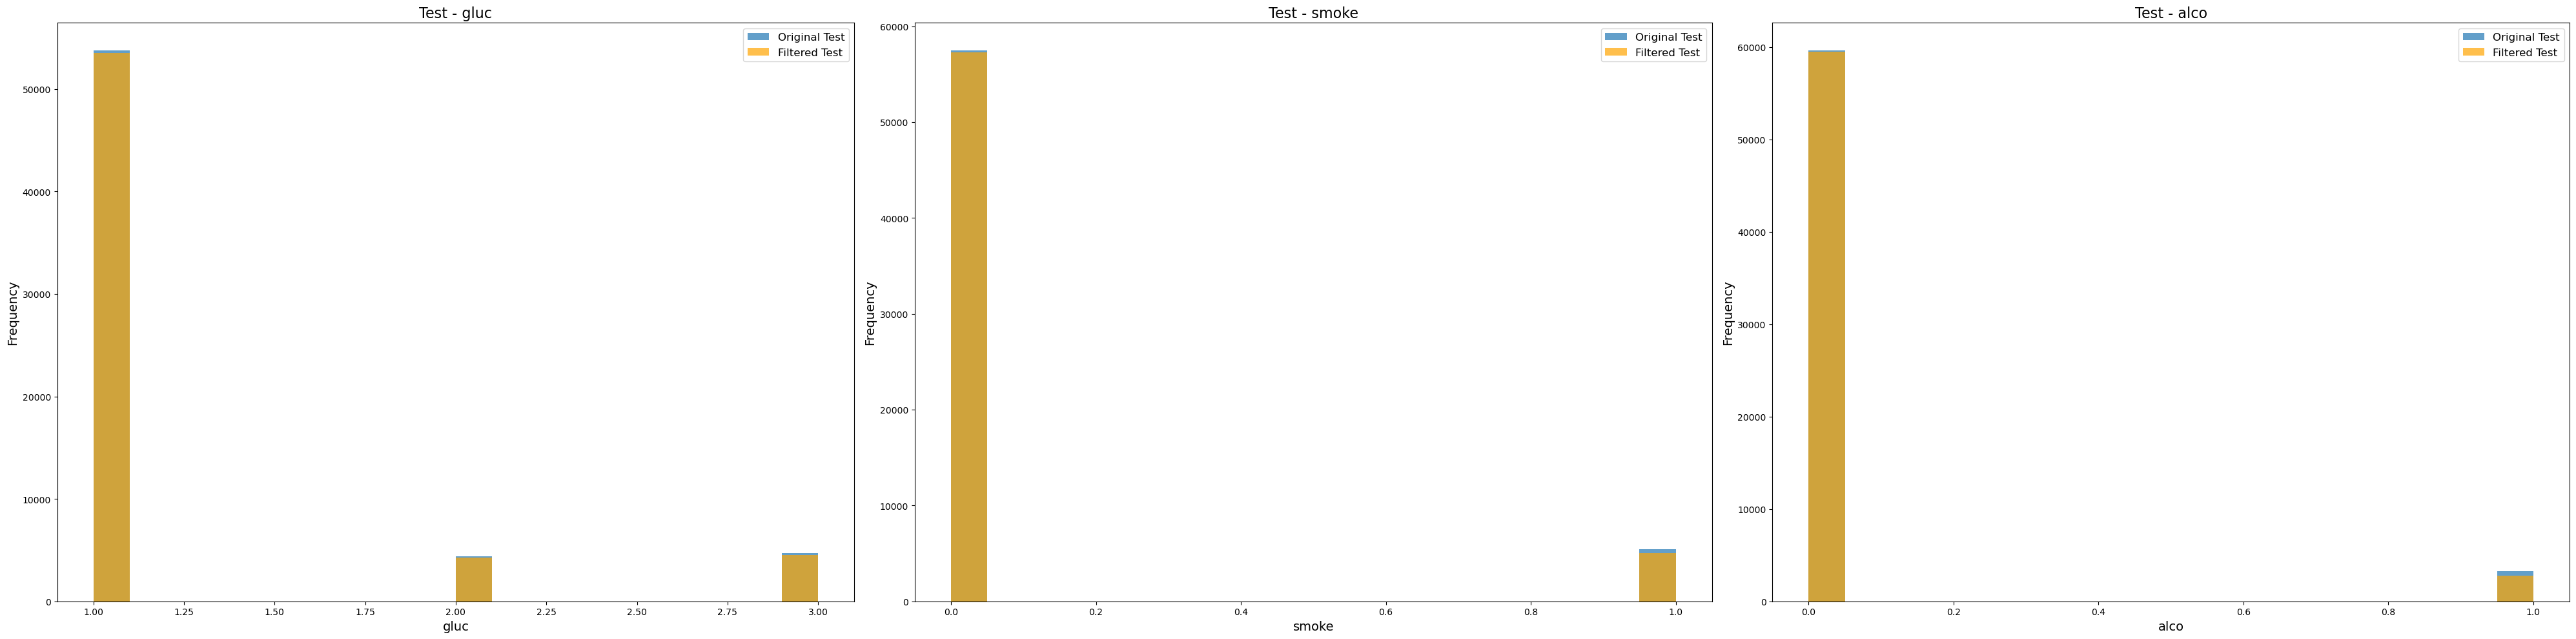

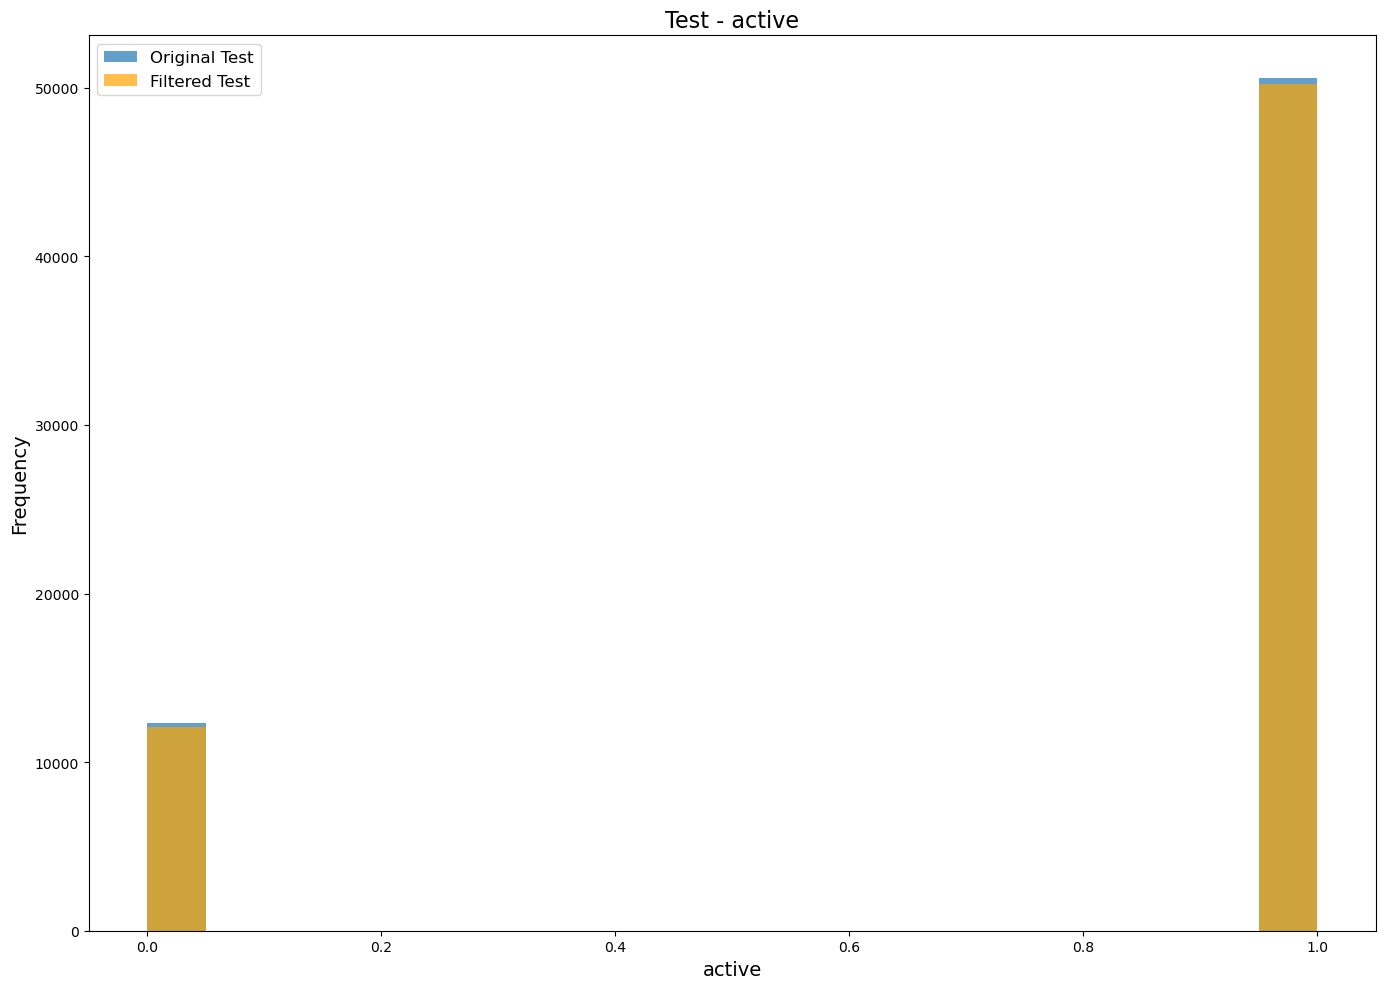

In [31]:
features_to_plot = ['age','gender', 'ap_hi', 'ap_lo', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
chunks = [features_to_plot[x:x+3] for x in range(0, len(features_to_plot), 3)]

for chunk in chunks:
    plt.figure(figsize=(40, 10))  #
    for i, feature in enumerate(chunk):
        plt.subplot(1, 3, i + 1) 
        plt.hist(X_no[feature], bins=20, alpha=0.7, label='Original Test')
        plt.hist(X_no_iso[feature], bins=20, alpha=0.7, label='Filtered Test', color='orange')
        plt.title(f'Test - {feature}', fontsize=16)  
        plt.xlabel(feature, fontsize=14)  
        plt.ylabel('Frequency', fontsize=14)  
        plt.legend(fontsize=12)  
    plt.tight_layout()  
    plt.show()

In [33]:
continuous_features_data = X_no_iso [['ap_hi', 'ap_lo','weight']]

# Dimensionaility Reduction

# PCA 

In [34]:
pca = PCA(n_components=2)

continuous_features_data = X_no_iso.select_dtypes(include=[np.number])
continuous_features_pca = pca.fit_transform(continuous_features_data)

continuous_features_pca

array([[-18.9545975 ,   3.94652329],
       [ 19.34905913,  -4.82446143],
       [ -4.82353325,   8.08694741],
       ...,
       [ -4.82732227,  -5.20471111],
       [  7.03498429,   4.27318746],
       [ -6.07025101,  -1.37739392]])

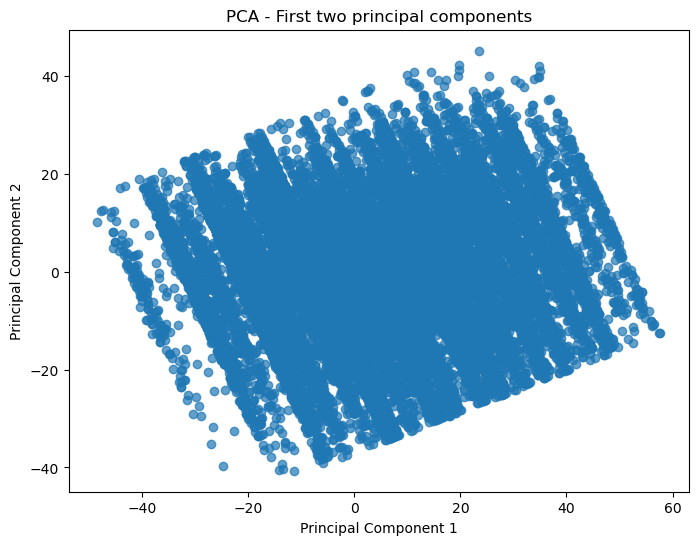

In [35]:
import matplotlib.pyplot as plt

pca_X = pd.DataFrame(data=continuous_features_pca, columns=['PC1', 'PC2'])

# Saçılım grafiği çiz
plt.figure(figsize=(8, 6))
plt.scatter(pca_X['PC1'], pca_X['PC2'], alpha=0.7)
plt.title('PCA - First two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Comparing the variance of the original data set and the data set after PCA


Original Variance: 455.18220972495925
Variance after PCA: 385.5862399796158
Explained variance ratio: [0.55970266 0.28740039]


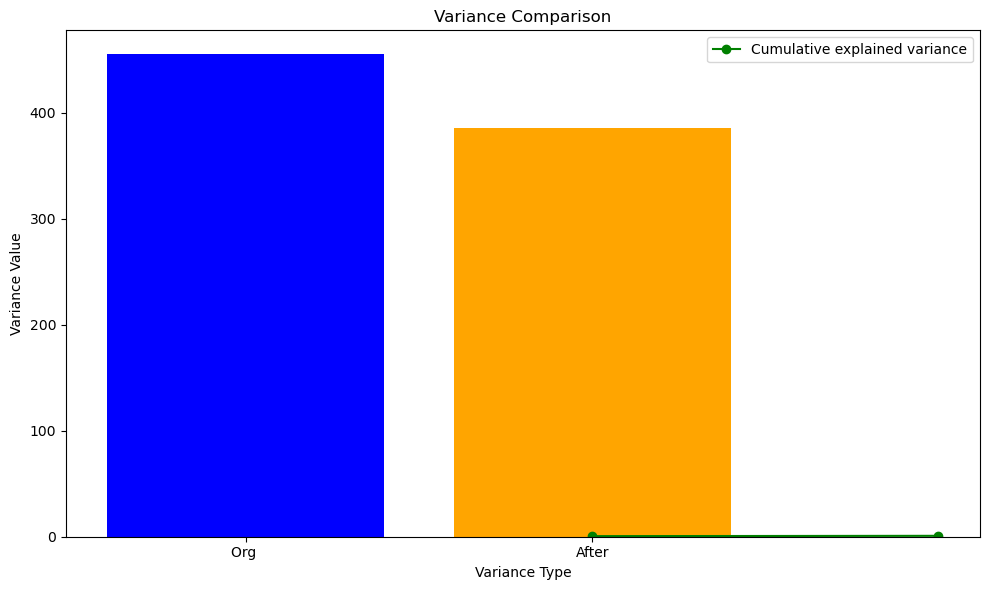

In [36]:
print("Original Variance:", continuous_features_data.var().sum())
print("Variance after PCA:", pca.explained_variance_.sum())

print("Explained variance ratio:", pca.explained_variance_ratio_)

original_variance = continuous_features_data.var().sum()

variance_after_pca = pca.explained_variance_.sum()

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))

plt.bar(['Org ', 'After'], [original_variance, variance_after_pca], color=['blue', 'orange'])

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='green', label='Cumulative explained variance')

plt.title('Variance Comparison')
plt.ylabel('Variance Value')
plt.xlabel('Variance Type')
plt.legend(loc='best')
plt.tight_layout()

In [37]:
pca_noise_reduced = PCA(n_components=2)
reduced_features = pca_noise_reduced.fit_transform(continuous_features_data)
reduced_features

array([[-18.9545975 ,   3.94652329],
       [ 19.34905913,  -4.82446143],
       [ -4.82353325,   8.08694741],
       ...,
       [ -4.82732227,  -5.20471111],
       [  7.03498429,   4.27318746],
       [ -6.07025101,  -1.37739392]])

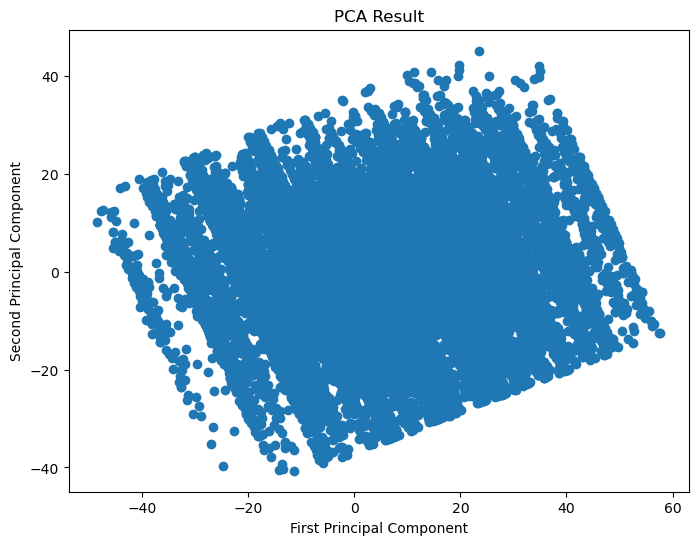

(62289, 2)

In [38]:
plt.figure(figsize = (8,6))
plt.scatter(reduced_features[:, 0],reduced_features[:, 1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Result')
plt.show()
reduced_features.shape

# Train-test Split


In [39]:
y=X_no_iso['cardio']

X_new= X_no_iso.drop('cardio', axis=1)

X_train,X_test, y_train, y_test= train_test_split(X_new,y, test_size=0.3, random_state=42)


In [43]:
X_train.shape

(43602, 10)

In [44]:
for column in X_train.columns:
        # Sütunun değerlerini say ve oranlarını hesapla
        value_counts = X_train[column].value_counts()
        print(value_counts)

age
56.0    3763
54.0    3730
58.0    3614
60.0    3392
50.0    3310
52.0    3307
64.0    2447
62.0    2429
48.0    1939
46.0    1846
44.0    1762
40.0    1659
42.0    1609
55.0     952
57.0     911
59.0     883
53.0     862
51.0     841
61.0     767
49.0     663
63.0     626
47.0     506
45.0     481
41.0     460
43.0     396
65.0     228
39.0     219
Name: count, dtype: int64
gender
1    28536
2    15066
Name: count, dtype: int64
weight
65.0    2480
70.0    2462
68.0    1817
75.0    1780
80.0    1733
        ... 
58.8       1
80.7       1
70.3       1
68.4       1
53.5       1
Name: count, Length: 155, dtype: int64
ap_hi
120    18640
140     6132
130     5858
110     5684
150     2718
       ...  
158        3
157        3
161        2
169        2
96         1
Name: count, Length: 74, dtype: int64
ap_lo
80     23657
90      9355
70      7056
100     2280
79       241
85       192
75       144
95       109
89        85
69        67
65        65
82        25
83        22
84        21


In [45]:
X_test.shape

(18687, 10)

# CHI2 Select KBest

In [49]:
categorical_features_train = X_train[['smoke', 'alco', 'active','gender','cholesterol','age','gluc']]
chi2_selector = SelectKBest(chi2, k=2)
chi2_selector.fit(categorical_features_train, y_train)
categorical_features_kbest_train = chi2_selector.transform(categorical_features_train)

categorical_features_test = X_test[['smoke', 'alco', 'active','gender','cholesterol','age','gluc']]
categorical_features_kbest_test = chi2_selector.transform(categorical_features_train)

categorical_features_kbest_train,categorical_features_kbest_test

(array([[ 1., 64.],
        [ 1., 50.],
        [ 1., 44.],
        ...,
        [ 3., 63.],
        [ 1., 49.],
        [ 1., 50.]]),
 array([[ 1., 64.],
        [ 1., 50.],
        [ 1., 44.],
        ...,
        [ 3., 63.],
        [ 1., 49.],
        [ 1., 50.]]))

In [50]:

selected_features = [categorical_features_train.columns[i] for i in chi2_selector.get_support(indices=True)]

selected_train_df = pd.DataFrame(categorical_features_kbest_train, columns=selected_features)
selected_test_df = pd.DataFrame(categorical_features_kbest_test, columns=selected_features)

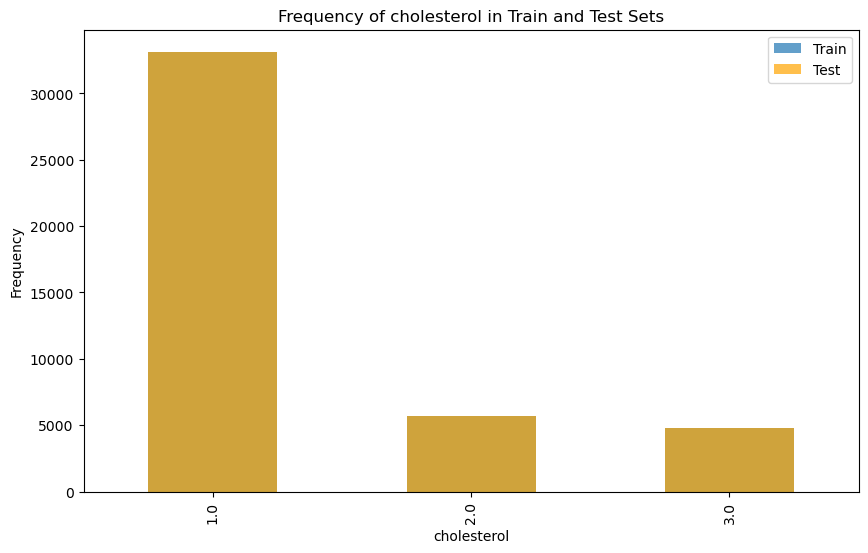

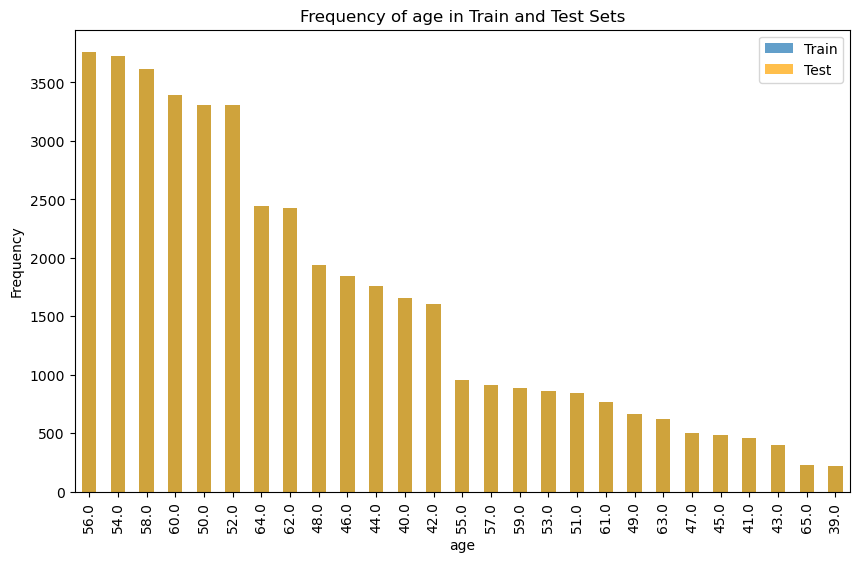

In [51]:

for feature in selected_features:
        plt.figure(figsize=(10, 6))
        selected_train_df[feature].value_counts().plot(kind='bar', alpha=0.7, label='Train')
        selected_test_df[feature].value_counts().plot(kind='bar', alpha=0.7, label='Test', color='orange')
        plt.title(f'Frequency of {feature} in Train and Test Sets')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

# Feature Selection

## Using CHI2 Select KBest


In [52]:
chi2_selector = SelectKBest(chi2, k=2)
chi2_selector.fit(categorical_features_train, y_train)

SelectKBest(k=2, score_func=<function chi2 at 0x000002329F35AD40>)

In [54]:
scores = chi2_selector.scores_
p_values = chi2_selector.pvalues_

feature_p_values= dict(zip(categorical_features_train.columns,p_values))

for feature, p_value in feature_p_values.items():
    print(f"{feature}: {p_value}")

smoke: 3.739367752509859e-11
alco: 6.300431398979975e-08
active: 0.0003567378330401158
gender: 0.547173182614905
cholesterol: 9.812609022072858e-153
age: 0.0
gluc: 2.3180802865817168e-20


In [55]:
for i in p_values:
    values_in_decimal = format(i,'.10f')
    print(values_in_decimal)

0.0000000000
0.0000000630
0.0003567378
0.5471731826
0.0000000000
0.0000000000
0.0000000000


Ignore glucose, age and cholesterol (near to zero)

In [56]:
# Print the scores and p-values for each feature
for feature, score, pval in zip(categorical_features_train.columns, scores, p_values):
    print(f"Feature: {feature}, Chi2 Score: {score}, P-value: {pval}")

Feature: smoke, Chi2 Score: 43.745702241957225, P-value: 3.739367752509859e-11
Feature: alco, Chi2 Score: 29.268728377319608, P-value: 6.300431398979975e-08
Feature: active, Chi2 Score: 12.746175670831608, P-value: 0.0003567378330401158
Feature: gender, Chi2 Score: 0.3624057269740042, P-value: 0.547173182614905
Feature: cholesterol, Chi2 Score: 693.0281731629614, P-value: 9.812609022072858e-153
Feature: age, Chi2 Score: 2069.351781441918, P-value: 0.0
Feature: gluc, Chi2 Score: 85.49909194284223, P-value: 2.3180802865817168e-20


"""
p_value less than 0.05 gender 
"""

In [57]:
X_train_reduced =X_train.drop(['gender'],axis = 1)

X_train_reduced

,age,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
57346,64.0,65.0,120,80,1,1,0,0,1
41830,50.0,65.0,120,80,1,1,0,0,1
15370,44.0,70.0,120,80,1,1,0,0,1
38292,56.0,63.0,120,85,1,1,0,0,1
20560,39.0,76.0,100,69,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
61068,52.0,85.0,120,80,1,1,0,0,0
42853,50.0,80.0,120,80,1,1,0,0,1
966,63.0,73.0,137,86,3,1,0,0,1
17648,49.0,65.0,120,80,1,1,0,0,1


In [58]:
X_test_reduced = X_test.drop(['gender'],axis = 1)

X_test_reduced

,age,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
64486,47.0,63.0,120,80,1,1,0,0,1
19240,46.0,59.0,110,70,1,1,0,0,1
44463,60.0,75.0,120,80,2,2,0,0,1
45304,57.0,75.0,120,80,1,1,0,0,1
15624,60.0,66.0,120,80,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
63962,64.0,68.0,120,80,1,1,0,0,0
64610,50.0,65.0,120,90,1,1,0,0,1
29246,58.0,93.0,130,90,3,3,0,0,1
11505,52.0,73.0,130,90,1,1,1,0,1


# RFE (Recursive Feature Elimination)

In [59]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

rfe = RFE(model, n_features_to_select=5)

rfe.fit(X_train_reduced, y_train)

print("Selected features: ", X_train_reduced.columns[rfe.support_])

Selected features:  Index(['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol'], dtype='object')


### alcohol and smoke not selected.

## Correlation of 'alco' and 'smoke' usage with 'y_train'

## Correlate usage of 'alco' and 'smoke' with other features in 'X_train'

## The correlation of data with values of 0 cannot be calculated

In [60]:
correlation_with_target = X_train[['alco', 'smoke']].join(y_train).corr()['cardio'].drop('cardio')
print("Correlation between Target:")
print(correlation_with_target)

features_correlation = X_train[['alco', 'smoke','active', 'age', 'weight']].corr()
print("\nCorrelation between Train set :")
print(features_correlation)

Correlation between Target:
alco    -0.026521
smoke   -0.033051
Name: cardio, dtype: float64

Correlation between Train set :
            alco     smoke    active       age    weight
alco    1.000000  0.312324  0.040626 -0.029033  0.033281
smoke   0.312324  1.000000  0.035376 -0.045452  0.048662
active  0.040626  0.035376  1.000000 -0.004060 -0.011197
age    -0.029033 -0.045452 -0.004060  1.000000  0.058942
weight  0.033281  0.048662 -0.011197  0.058942  1.000000


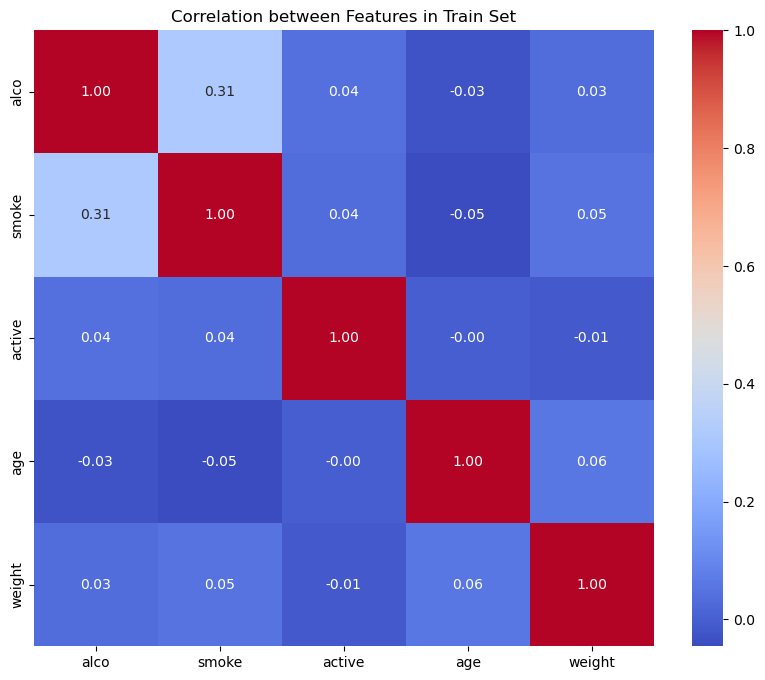

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(features_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Features in Train Set")
plt.show()

In [62]:
X_train.reset_index()

,index,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,57346,64.0,1,65.0,120,80,1,1,0,0,1
1,41830,50.0,1,65.0,120,80,1,1,0,0,1
2,15370,44.0,1,70.0,120,80,1,1,0,0,1
3,38292,56.0,1,63.0,120,85,1,1,0,0,1
4,20560,39.0,2,76.0,100,69,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
43597,61068,52.0,1,85.0,120,80,1,1,0,0,0
43598,42853,50.0,2,80.0,120,80,1,1,0,0,1
43599,966,63.0,1,73.0,137,86,3,1,0,0,1
43600,17648,49.0,2,65.0,120,80,1,1,0,0,1


# Model Algorithms

# Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model with train data
logistic_model.fit(X_train_reduced,y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [64]:
X_train_reduced.reset_index()


,index,age,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,57346,64.0,65.0,120,80,1,1,0,0,1
1,41830,50.0,65.0,120,80,1,1,0,0,1
2,15370,44.0,70.0,120,80,1,1,0,0,1
3,38292,56.0,63.0,120,85,1,1,0,0,1
4,20560,39.0,76.0,100,69,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
43597,61068,52.0,85.0,120,80,1,1,0,0,0
43598,42853,50.0,80.0,120,80,1,1,0,0,1
43599,966,63.0,73.0,137,86,3,1,0,0,1
43600,17648,49.0,65.0,120,80,1,1,0,0,1


In [65]:
user_input = {
    'age' : 40.0,
    'weight' : 86.0,
    'ap_hi' : 130,
    'ap_lo' : 70,
    'cholesterol' : 3,
    'gluc' : 1,
    'smoke' : 0,
    'alco' : 1,
    'active' : 1,
}

In [66]:
user_input_df = pd.DataFrame([user_input])

prediction_logistic = logistic_model.predict(user_input_df)

In [67]:
prediction_result_logistic= "Risk(1)" if prediction_logistic[0]==1 else "Not in risk(0)"
print(prediction_result_logistic)


Risk(1)


In [68]:

from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(logistic_model, X_train, y_train, cv=kf, scoring='accuracy')

print("Average Accuracy for Logistic Regression:", accuracy_scores.mean())

Average Accuracy for Logistic Regression: 0.7253337746386714


In [82]:
from sklearn.metrics import f1_score

y_pred= logistic_model.predict(X_test_reduced)

f1 = f1_score(y_test, y_pred)

print(f"F1-score for the Logistic Regression model: {f1}")

F1-score for the Logistic Regression model: 0.6998221763322434


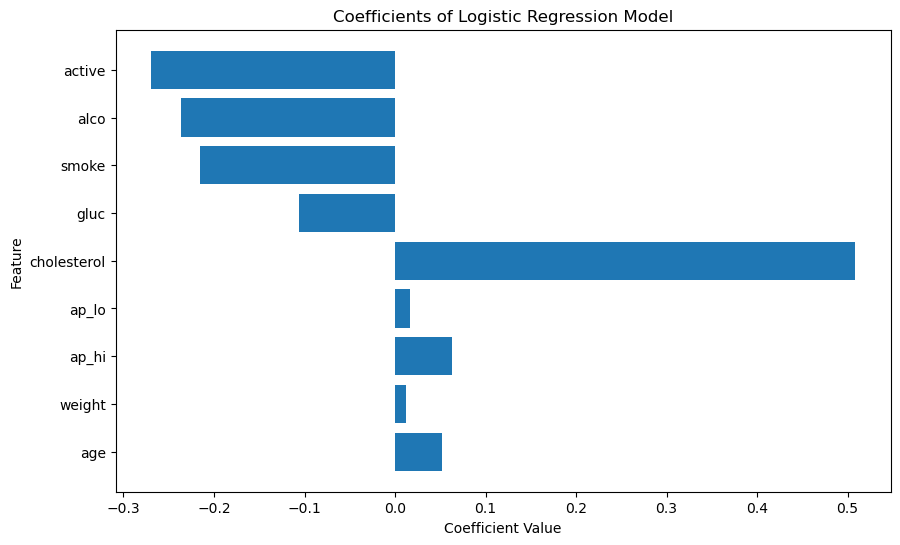

In [70]:
coefficients = logistic_model.coef_[0]
features = X_train_reduced.columns
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Coefficients of Logistic Regression Model")
plt.show()

# Decision Tree Classifier

In [71]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_reduced, y_train)

DecisionTreeClassifier(random_state=42)

In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores_decision_tree = cross_val_score(decision_tree_model, X_train_reduced, y_train, cv=kf, scoring='accuracy')
print("Average Accuracy for Decision Tree:", accuracy_scores_decision_tree.mean())

Average Accuracy for Decision Tree: 0.6521491043973789


In [80]:
from sklearn.metrics import f1_score

y_pred = decision_tree_model.predict(X_test_reduced)

f1 = f1_score(y_test, y_pred)

print(f"F1-score for the Decision Tree Model: {f1}")

F1-score for the Decision Tree Model: 0.6260778980265062


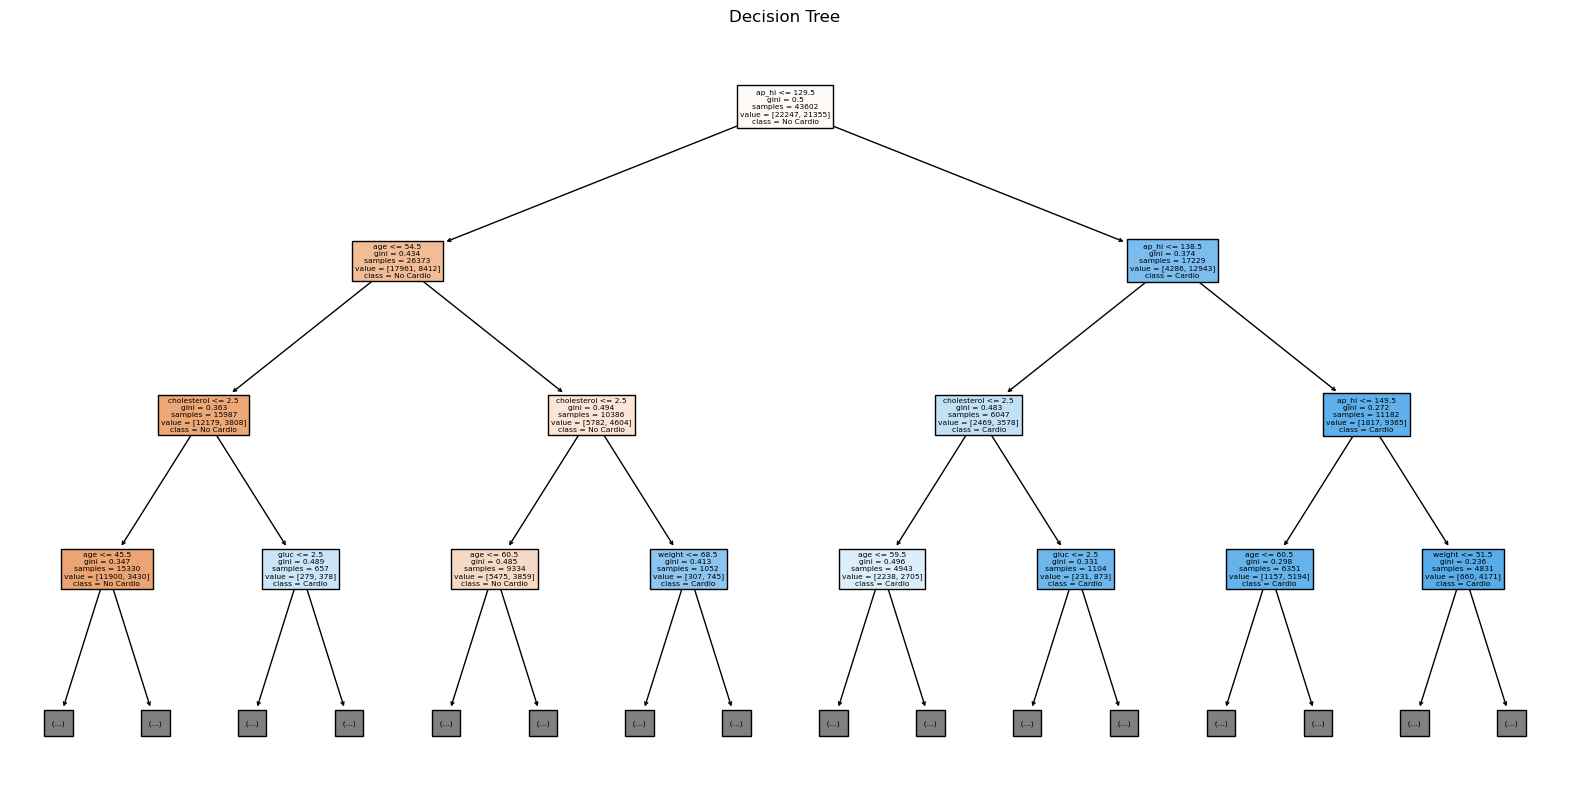

In [74]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, filled=True, feature_names=list(X_train_reduced.columns), class_names=['No Cardio', 'Cardio'], max_depth=3)
plt.title("Decision Tree")
plt.show()

In [75]:
prediction_decision = decision_tree_model.predict(user_input_df)

prediction_result_decison= "Risk(1)" if prediction_decision[0]==1 else "Not in risk(0)"
print(prediction_result_decison)

Risk(1)


# Random Forest Classifier

In [76]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_reduced, y_train)

RandomForestClassifier(random_state=42)

In [77]:
accuracy_scores_random_forest = cross_val_score(random_forest_model, X_train_reduced, y_train, cv=kf, scoring='accuracy')
print("Average Accuracy for Random Forest:", accuracy_scores_random_forest.mean())


Average Accuracy for Random Forest: 0.6872621343188275


In [78]:
from sklearn.metrics import f1_score

y_pred = random_forest_model.predict(X_test_reduced)

f1 = f1_score(y_test, y_pred)

print(f"F1-score for the Random Forest Model: {f1}")

F1-score for the Random Forest Model: 0.6782763019244633


In [83]:
feature_importances = random_forest_model.feature_importances_
features = X_train_reduced.columns

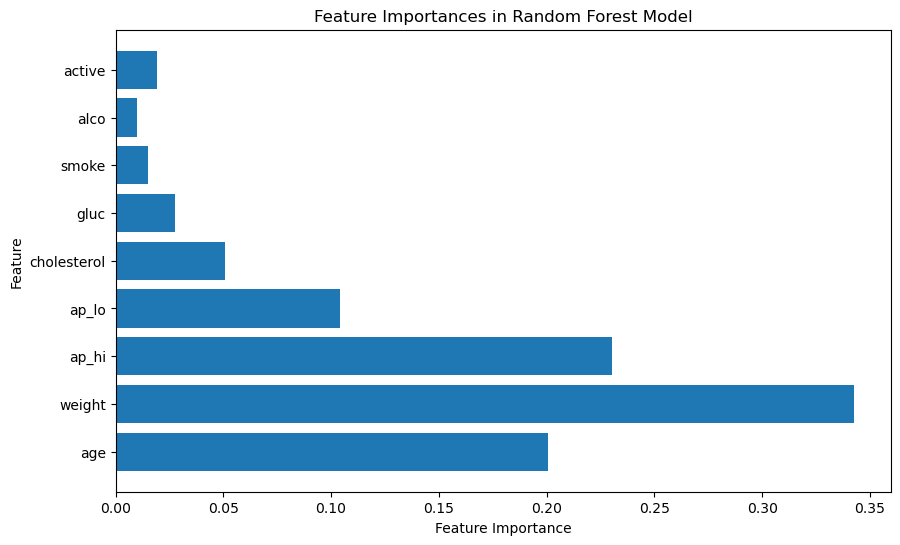

In [84]:

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in Random Forest Model")
plt.show()

In [85]:
prediction_forest =  random_forest_model.predict(user_input_df)

prediction_result_forest= "Risk(1)" if prediction_forest[0]==1 else "Not in risk(0)"
print(prediction_result_forest)

Risk(1)


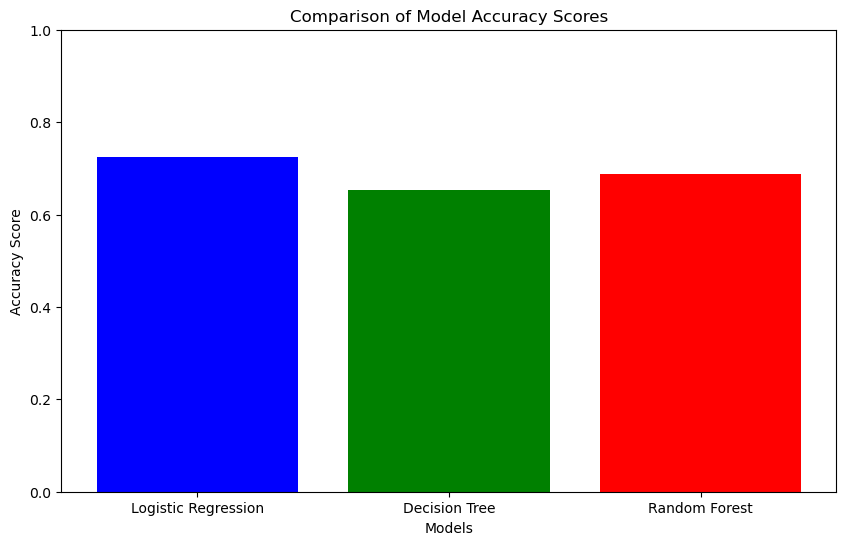

In [86]:
accuracy_scores = {
    'Logistic Regression': 0.7253337746386714,
    'Decision Tree': 0.6521491043973789,
    'Random Forest': 0.6872621343188275,
}

plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Accuracy Scores')
plt.ylim([0, 1])
plt.show()

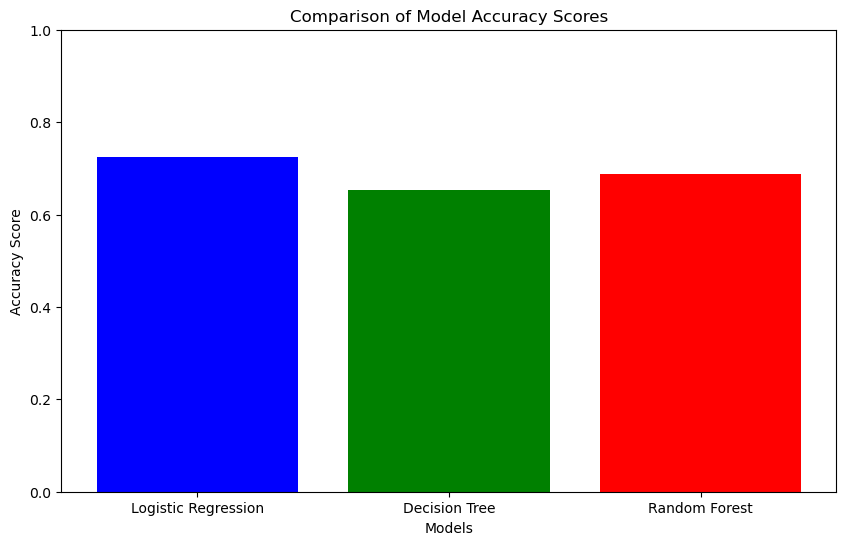

In [87]:
F1_scores = {
    'Logistic Regression': 0.6998221763322434,
    'Decision Tree': 0.6260778980265062,
    'Random Forest':  0.6782763019244633,
}

plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Accuracy Scores')
plt.ylim([0, 1])
plt.show()

In [101]:
# Eğitim setini birleştir
train_set = X_train_reduced.copy()
train_set['cardio'] = y_train

# Test setini birleştir
test_set = X_test_reduced.copy()
test_set['cardio'] = y_test

# Eğitim ve test setlerini birleştir
combined_set = pd.concat([train_set, test_set])





In [102]:
combined_set

,age,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
57346,64.0,65.0,120,80,1,1,0,0,1,0
41830,50.0,65.0,120,80,1,1,0,0,1,0
15370,44.0,70.0,120,80,1,1,0,0,1,0
38292,56.0,63.0,120,85,1,1,0,0,1,0
20560,39.0,76.0,100,69,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
63962,64.0,68.0,120,80,1,1,0,0,0,1
64610,50.0,65.0,120,90,1,1,0,0,1,1
29246,58.0,93.0,130,90,3,3,0,0,1,0
11505,52.0,73.0,130,90,1,1,1,0,1,1


In [107]:
combined_set.to_csv('cardio_train_prepared.csv')